In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 2000)
import matplotlib.pyplot as plt
import math
import time
import random
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

import gc

import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold, train_test_split

import torch.optim as optim

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

In [2]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


# Functions

In [3]:
class StratifiedKFold3(StratifiedKFold):

    def split(self, X, y, groups=None):
        s = super().split(X, y, groups)
        for train_indxs, test_indxs in s:
            y_train = y[train_indxs]
            train_indxs, cv_indxs = train_test_split(train_indxs,stratify=y_train, test_size=(1 / (self.n_splits - 1)), random_state=0)
            yield train_indxs, cv_indxs, test_indxs

In [4]:
# Function to split data so even distribution between val and test
def cv_data_fun(data, n_cv=10):
    X = data.iloc[:, 2:]
    y = data['po_flag']
    g = StratifiedKFold3(n_cv).split(X,y)
    return g

In [5]:
# Define how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# Calculate the number of trainable parameters in the model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
from typing import Counter
from imblearn.over_sampling import SMOTE

def smote_fun(train_data):
    # Oversampling train set
    train_data_X = train_data.drop(columns=['stay_id', 'po_flag'])
    train_data_y = train_data['po_flag']
    Counter(train_data_y)
    oversample = SMOTE()
    train_data_X, train_data_y = oversample.fit_resample(train_data_X, train_data_y)
    Counter(train_data_y)
    train_data_y = pd.DataFrame(train_data_y, columns=['po_flag'])
    train_data_y['stay_id'] = 'x'
    train_data = pd.concat([train_data_y, train_data_X], axis=1)
    train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)
    return train_data

In [7]:
def set_transformer_processing_fun(patient_df, snomed_embedding):
    # Str
    patient_df.columns = patient_df.columns.astype(str)
    snomed_embedding['snomed_code'] = snomed_embedding['snomed_code'].astype(str)
    # Filter
    snomed_embedding = snomed_embedding[snomed_embedding['snomed_code'].isin(patient_df.columns.tolist())]
    snomed_embedding.set_index('snomed_code', inplace=True)
    # Get lengths of each patients co-morbidities
    comorbidity_len = np.array(patient_df.sum(axis=1))
    # Add padding embedding 
    padding_df = pd.DataFrame(np.random.choice([0], size=len(snomed_embedding.columns))) # Changed to 0
    padding_df = padding_df.T
    padding_df.index = ['9999999999']
    padding_df.columns = snomed_embedding.columns
    snomed_embedding2 = pd.concat([snomed_embedding, padding_df])
    snomed_embedding2.index = snomed_embedding2.index.astype(str)
    # Get max number of co-morbidities
    max_len = 22 # Define for same for all splits (train val etr)
    # Format patients embeddings into set and pad / create array
    feature_array = np.zeros(shape=(len(patient_df), max_len , 128))
    n = -1
    for index, row in patient_df.iterrows():
        n += 1
        n2 = -1
        code_list = row[row ==1].index.tolist()
        while len(code_list) < max_len:
            code_list.append('9999999999')
        for code in code_list:
            n2 += 1
            feature_array[n, n2] = np.array(snomed_embedding2.loc[code])
    
    # Create mask tensor based on lengths
    comorbidity_len2 = torch.as_tensor(comorbidity_len, dtype=torch.long)
    mask = torch.arange(max_len)[None, :] < comorbidity_len2[:, None]

    return feature_array, mask

In [8]:
def new_threshold_fun(predictions, bound=0.5):
    new_predictions = [1 if a_ >= bound else 0 for a_ in predictions]
    return new_predictions

In [9]:
# Function to train and eval model 
def cv_run_fun(data, model):
    overall_best_test_auroc = 0

    actual_test_auroc_results = []

    test_auroc_results = []
    test_accuracy_results = []
    test_balanced_accuracy_results = []
    test_recall_results = []
    test_precision_results = []
    test_f1_results = []
    test_auprc_results = []
    test_cm_results = []
    test_true_positive_rate_results = []
    test_fasle_positive_rate_results = []

    final_threshold = 0

    # Define batch size 
    batch_size = 512

    # Define optimizer and learning_rate
    learning_rate = 0.0001
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    # Define epochs and clip
    N_EPOCHS = 10 
    CLIP = 1

    # Split into folds
    split_generator = cv_data_fun(data)

    # Iterate through folds
    for x in range(N_EPOCHS): # Note this only works as number of splits and epocs are the same
        train_idx, val_idx, test_idx = next(split_generator)

        # Get train val and test
        train_data = data.loc[train_idx]
        valid_data = data.loc[val_idx]
        test_data = data.loc[test_idx]

        #Apply smote - crashes with these features
        #train_data = smote_fun(train_data)

        # Split up dfs
        vitals_train_data = train_data.iloc[:,2:255]
        demographics_train_data = train_data.iloc[:,255:267]
        comorbidity_train_data = train_data.iloc[:, 267:]

        vitals_valid_data = valid_data.iloc[:,2:255]
        demographics_valid_data = valid_data.iloc[:,255:267]
        comorbidity_valid_data = valid_data.iloc[:, 267:]

        vitals_test_data = test_data.iloc[:,2:255]
        demographics_test_data = test_data.iloc[:,255:267]
        comorbidity_test_data = test_data.iloc[:, 267:]

        # Initializing the weights of our model each fold
        model.apply(init_weights)

        # Get labels
        train_labels = train_data[['po_flag']]
        valid_labels = valid_data[['po_flag']]
        test_labels = test_data[['po_flag']]

        # Preprocess comorbidity data
        print('Working on set_transformer_processing_fun...')
        comorbidity_train_data, comorbidity_train_mask = set_transformer_processing_fun(comorbidity_train_data, embedding)
        comorbidity_valid_data, comorbidity_valid_mask = set_transformer_processing_fun(comorbidity_valid_data, embedding)
        comorbidity_test_data, comorbidity_test_mask = set_transformer_processing_fun(comorbidity_test_data, embedding)
        print('Done!')

        # Define dataloaders
        train_dataset =  MultiInputDataset([vitals_train_data, demographics_train_data], train_labels, comorbidity_train_data, comorbidity_train_mask)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)#, shuffle=True)#, collate_fn=train_dataset.collate_fn_padd)

        valid_dataset = MultiInputDataset([vitals_valid_data, demographics_valid_data], valid_labels, comorbidity_valid_data, comorbidity_valid_mask)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size)#, collate_fn=valid_dataset.collate_fn_padd)

        test_dataset = MultiInputDataset([vitals_test_data, demographics_test_data], test_labels, comorbidity_test_data, comorbidity_test_mask)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)#, collate_fn=test_dataset.collate_fn_padd)

        # Run
        best_valid_loss = float('inf')
        best_valid_auroc = 0

        optimal_threshold = 0

        for epoch in range(N_EPOCHS):

            start_time = time.time()

            train_loss, train_auroc, train_predictions, train_labels_out = train(model, train_dataloader, optimizer, criterion, CLIP)

            valid_loss, valid_auroc, valid_predictions, valid_labels_out = evaluate(model, valid_dataloader, criterion)

            end_time = time.time()
            
            fpr, tpr, thresholds = roc_curve(valid_labels_out, valid_predictions)
            optimal_idx = np.argmax(tpr - fpr)
            current_threshold = thresholds[optimal_idx]

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print('Train AUROC:', train_auroc)
            print('Valid AUROC:', valid_auroc)
            print(train_predictions)
            print(train_labels_out)
            print('Train loss:', train_loss)
            print('Valid loss:', valid_loss)
            print(current_threshold)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                print('BEST VALID LOSS')

            if valid_auroc > best_valid_auroc:
                best_valid_auroc = valid_auroc
                print('UPDATED BEST INTERMEDIATE MODEL')
                torch.save(model.state_dict(), f'chronic_switch_model_intermediate2.pt')
                optimal_threshold = current_threshold

        # -----------------------------
        # Evaluate best model on test set
        # -----------------------------

        model.load_state_dict(torch.load(f'chronic_switch_model_intermediate2.pt'))

        test_loss, test_auroc, test_predictions, test_labels_out = evaluate(model, test_dataloader, criterion)

        print('Test AUROC result:', test_auroc)
        
        new_test_predictions = new_threshold_fun(test_predictions, optimal_threshold)

        test_accuracy = accuracy_score(test_labels_out, new_test_predictions)
        test_balanced_accuracy = balanced_accuracy_score(test_labels_out, new_test_predictions)
        test_recall = recall_score(test_labels_out, new_test_predictions)
        test_precision = precision_score(test_labels_out, new_test_predictions)
        test_f1 = f1_score(test_labels_out, new_test_predictions)
        test_auprc = average_precision_score(test_labels_out, test_predictions)
        test_cm = confusion_matrix(test_labels_out, new_test_predictions)
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))

        if test_auroc > overall_best_test_auroc:
            overall_best_test_auroc = test_auroc
            print('UPDATED BEST OVERALL MODEL')
            torch.save(model.state_dict(), f'chronic_switch_model.pt') # Hastag out when dont want to change
            final_threshold = optimal_threshold
        
        actual_test_auroc_results.append(test_auroc)
        
        test_auroc_results.append(test_auroc)
        test_accuracy_results.append(test_accuracy)
        test_balanced_accuracy_results.append(test_balanced_accuracy)
        test_recall_results.append(test_recall)
        test_precision_results.append(test_precision)
        test_f1_results.append(test_f1)
        test_auprc_results.append(test_auprc)
        test_cm_results.append(test_cm)
        test_true_positive_rate_results.append(test_true_positive_rate)
        test_fasle_positive_rate_results.append(test_false_positive_rate)

    test_results = [test_auroc_results, test_accuracy_results,
        test_balanced_accuracy_results,
        test_recall_results,
        test_precision_results,
        test_f1_results,
        test_auprc_results,
        test_cm_results,
        test_true_positive_rate_results,
        test_fasle_positive_rate_results
        ]
    
    return test_results, actual_test_auroc_results, final_threshold

In [10]:
def analyze_results_fun(cv_test_results):
    # Assign results
    test_auroc_results, test_accuracy_results,test_balanced_accuracy_results,test_recall_results,test_precision_results,test_f1_results,test_auprc_results,test_cm_results, test_tpr_results, test_fpr_results = [cv_test_results[i] for i in range(len(cv_test_results))]
    print('mean test_auroc:', np.array(test_auroc_results).mean())
    print('std test_auroc:', np.array(test_auroc_results).std())
    print('test_auroc 2.5th percentile:', max(0, np.percentile(test_auroc_results, 2.5)))
    print('test_auroc 97.5th percentile:', min(1, np.percentile(test_auroc_results, 97.5)))
    print('mean test_accuracy:', np.array(test_accuracy_results).mean())
    print('std test_accuracy:', np.array(test_accuracy_results).std())
    print('test_accuracy 2.5th percentile:', max(0, np.percentile(test_accuracy_results, 2.5)))
    print('test_accuracy 97.5th percentile:', min(1, np.percentile(test_accuracy_results, 97.5)))
    print('mean test_balanced_accuracy:', np.array(test_balanced_accuracy_results).mean())
    print('std test_balanced_accuracy:', np.array(test_balanced_accuracy_results).std())
    print('test_balanced_accuracy 2.5th percentile:', max(0, np.percentile(test_balanced_accuracy_results, 2.5)))
    print('test_balanced_accuracy 97.5th percentile:', min(1, np.percentile(test_balanced_accuracy_results, 97.5)))
    print('mean test_recall:', np.array(test_recall_results).mean())
    print('std test_recall:', np.array(test_recall_results).std())
    print('test_recall 2.5th percentile:', max(0, np.percentile(test_recall_results, 2.5)))
    print('test_recall 97.5th percentile:', min(1, np.percentile(test_recall_results, 97.5)))
    print('mean test_precision:', np.array(test_precision_results).mean())
    print('std test_precision:', np.array(test_precision_results).std())
    print('test_precision 2.5th percentile:', max(0, np.percentile(test_precision_results, 2.5)))
    print('test_precision 97.5th percentile:', min(1, np.percentile(test_precision_results, 97.5)))
    print('mean test_f1:', np.array(test_f1_results).mean())
    print('std test_f1:', np.array(test_f1_results).std())
    print('test_f1 2.5th percentile:', max(0, np.percentile(test_f1_results, 2.5)))
    print('test_f1 97.5th percentile:', min(1, np.percentile(test_f1_results, 97.5)))
    print('mean test_auprc:', np.array(test_auprc_results).mean())
    print('std test_auprc:', np.array(test_auprc_results).std())
    print('test_auprc 2.5th percentile:', max(0, np.percentile(test_auprc_results, 2.5)))
    print('test_auprc 97.5th percentile:', min(1, np.percentile(test_auprc_results, 97.5)))
    print('mean test_tpr:', np.array(test_tpr_results).mean())
    print('std test_tpr:', np.array(test_tpr_results).std())
    print('test_tpr 2.5th percentile:', max(0, np.percentile(test_tpr_results, 2.5)))
    print('test_tpr 97.5th percentile:', min(1, np.percentile(test_tpr_results, 97.5)))
    print('mean test_fpr:', np.array(test_fpr_results).mean())
    print('std test_fpr:', np.array(test_fpr_results).std())
    print('test_fpr 2.5th percentile:', max(0, np.percentile(test_fpr_results, 2.5)))
    print('test_fpr 97.5th percentile:', min(1, np.percentile(test_fpr_results, 97.5)))

In [11]:
# Train
def train(model, dataloader, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    batch_prediction_list = []
    batch_label_list = []

    for batch_idx, sample in enumerate(tqdm(dataloader)):
        labels = sample["labels"]
        features = sample["features"]
        batch_mask = sample["mask"]
        features = [data.float() for data in features]
        features = [data.to(device=device) for data in features]
        labels = labels.float()
        labels = labels.to(device=device)
        batch_mask = batch_mask.to(device)

        # zero the gradients calculated from the last batch
        optimizer.zero_grad()

        # Run model
        output = model(features, batch_mask)
        
        # Generate loss
        loss = criterion(output, labels)

        # calculate the gradients
        loss.backward()

        # update the parameters of our model by doing an optimizer step
        optimizer.step()

        epoch_loss += loss.item()

        # Get predictions for performance calc - masking outputs and labels
        sig = torch.nn.Sigmoid()
        output = sig(output)      
        np_predictions = output.cpu().detach().numpy()
        np_labels = labels.cpu().detach().numpy()

        np_predictions = np_predictions.squeeze()
        np_labels = np_labels.squeeze()

        np_predictions = np_predictions.flatten()
        np_labels = np_labels.flatten()
        
        # Create list
        for x in np_predictions:
            batch_prediction_list.append(x)
        for x in np_labels:
            batch_label_list.append(x)

    final_predictions = np.array(batch_prediction_list)

    final_labels = np.array(batch_label_list)

    try:
        auroc = roc_auc_score(final_labels, final_predictions)
    except:
        auroc = np.nan
    
    try:
        final_loss = epoch_loss / len(dataloader)
    except:
        final_loss = np.nan

    return final_loss, auroc, final_predictions, final_labels

In [12]:
def evaluate(model, dataloader, criterion):

    # Set the model to evaluation mode
    model.eval()

    epoch_loss = 0

    batch_prediction_list = []
    batch_label_list = []

    # use the with torch.no_grad() block to ensure no gradients are calculated within the bloc
    with torch.no_grad():
        for batch_idx, sample in enumerate(tqdm(dataloader)):
            labels = sample["labels"]
            features = sample["features"]
            batch_mask = sample["mask"]
            features = [data.float() for data in features]
            features = [data.to(device=device) for data in features]
            labels = labels.float()
            labels = labels.to(device=device)
            batch_mask = batch_mask.to(device)

            # Run model
            output = model(features, batch_mask)

            # Generate loss
            loss = criterion(output, labels)

            epoch_loss += loss.item()

            # Get predictions for performance calc - masking outputs and labels
            sig = torch.nn.Sigmoid()
            output = sig(output)  
            np_predictions = output.cpu().detach().numpy()
            np_labels = labels.cpu().detach().numpy()

            np_predictions = np_predictions.squeeze()
            np_labels = np_labels.squeeze()

            np_predictions = np_predictions.flatten()
            np_labels = np_labels.flatten()
            
            # Create list
            for x in np_predictions:
                batch_prediction_list.append(x)
            for x in np_labels:
                batch_label_list.append(x)

        final_predictions = np.array(batch_prediction_list)

        final_labels = np.array(batch_label_list)

        try:
            auroc = roc_auc_score(final_labels, final_predictions)
        except:
            auroc = np.nan
        
        try:
            final_loss = epoch_loss / len(dataloader)
        except:
            final_loss = np.nan

        return final_loss, auroc, final_predictions, final_labels

In [13]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=36, dim_hidden=160, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.isab = ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln)
        self.pma = PMA(dim_hidden, num_heads, num_outputs, ln=ln)
        self.dec = nn.Sequential(
                #SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                #SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X, batch_mask):
        x = self.isab(X, batch_mask)
        x = self.pma(x, batch_mask)
        return self.dec(x)

class MAB0(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB0, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K, mask):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        # Create new variable for softmax
        WB_ = Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V)
        # Exspand mask dimensions to align
        mask = mask.unsqueeze(1).repeat(self.num_heads, Q.shape[1], 1)
        # Mask for softmax
        WB_[~mask] = float('-inf')
        A = torch.softmax(WB_, 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB0(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X, mask):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X, mask)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB0(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X, mask):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X, mask)

In [14]:
class Initial_vitals_model(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, dropout):
        super().__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout))

    def forward(self, x):
        
        x1 = self.layers(x)

        return x1


class Chronic_switch_model(nn.Module):
    def __init__(self, 
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout):
        super().__init__()

        self.final_layers = nn.Sequential(
            nn.Linear(final_input_dim, final_hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hid_dim, final_hid_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hid_dim2, final_output_dim),
            nn.ReLU(),
            nn.Dropout(dropout))

        self.vital_model = Initial_vitals_model(vital_input_dim, vital_output_dim, vital_hid_dim, dropout)

        self.set_transformer = SetTransformer(dim_input=128, num_outputs=1, dim_output=128, num_inds=32, dim_hidden=160, num_heads=4, ln=False)

        # Embedding for demographics (passing feature directly)
        self.demographics = nn.Linear(demographics_input_dim, demographics_output_dim)

    def forward(self, inputs: torch.Tensor, batch_mask: torch.Tensor) -> torch.Tensor:

        # Directly pass demographics feature to embedding
        demographics = self.demographics(inputs[1])

        # Pass other inputs through initial models
        vital_embeddings = self.vital_model(inputs[0])
        comorbidity_embeddings = self.set_transformer(inputs[2], batch_mask)
        comorbidity_embeddings = torch.squeeze(comorbidity_embeddings)

        # Concatenate embeddings
        concatenated_embeddings = torch.cat([demographics, vital_embeddings, comorbidity_embeddings], dim=1)

        # Pass through final layers
        output = self.final_layers(concatenated_embeddings)

        return output
    
    def latent_representation(self, inputs: torch.Tensor, batch_mask: torch.Tensor) -> torch.Tensor:

        # Directly pass demographics feature to embedding
        demographics = self.demographics(inputs[1])

        # Pass other inputs through initial models
        vital_embeddings = self.vital_model(inputs[0])
        comorbidity_embeddings = self.set_transformer(inputs[2], batch_mask)
        comorbidity_embeddings = torch.squeeze(comorbidity_embeddings)

        # Concatenate embeddings
        concatenated_embeddings = torch.cat([demographics, vital_embeddings, comorbidity_embeddings], dim=1)
        
        return concatenated_embeddings

In [6]:
columns_to_drop = [
 'Diastolic Blood Pressure2',
 'Diastolic Blood Pressure3',
 'Diastolic Blood Pressure4',
 'Diastolic Blood Pressure5',
 'Diastolic Blood Pressure6',
 'Diastolic Blood Pressure7',
 'Diastolic Blood Pressure8',
 'Diastolic Blood Pressure9',
 'Diastolic Blood Pressure11',
 'Diastolic Blood Pressure12',
 'Diastolic Blood Pressure13',
 'Diastolic Blood Pressure14',
 'Diastolic Blood Pressure15',
 'Diastolic Blood Pressure16',
 'Diastolic Blood Pressure18',
 'Diastolic Blood Pressure19',
 'Diastolic Blood Pressure20',
 'Diastolic Blood Pressure21',
 'Diastolic Blood Pressure2_current_stay',
 'Diastolic Blood Pressure3_current_stay',
 'Diastolic Blood Pressure4_current_stay',
 'Diastolic Blood Pressure5_current_stay',
 'Diastolic Blood Pressure6_current_stay',
 'Diastolic Blood Pressure8_current_stay',
 'Diastolic Blood Pressure12_current_stay',
 'Diastolic Blood Pressure13_current_stay',
 'Diastolic Blood Pressure14_current_stay',
 'Diastolic Blood Pressure16_current_stay',
 'Diastolic Blood Pressure18_current_stay',
 'Diastolic Blood Pressure19_current_stay',
 'Diastolic Blood Pressure20_current_stay',
 'Diastolic Blood Pressure21_current_stay',
 'Glasgow Coma Score0',
 'Glasgow Coma Score1',
 'Glasgow Coma Score2',
 'Glasgow Coma Score3',
 'Glasgow Coma Score4',
 'Glasgow Coma Score5',
 'Glasgow Coma Score6',
 'Glasgow Coma Score7',
 'Glasgow Coma Score8',
 'Glasgow Coma Score9',
 'Glasgow Coma Score10',
 'Glasgow Coma Score11',
 'Glasgow Coma Score12',
 'Glasgow Coma Score13',
 'Glasgow Coma Score14',
 'Glasgow Coma Score15',
 'Glasgow Coma Score16',
 'Glasgow Coma Score17',
 'Glasgow Coma Score18',
 'Glasgow Coma Score19',
 'Glasgow Coma Score20',
 'Glasgow Coma Score21',
 'Glasgow Coma Score0_current_stay',
 'Glasgow Coma Score1_current_stay',
 'Glasgow Coma Score2_current_stay',
 'Glasgow Coma Score3_current_stay',
 'Glasgow Coma Score4_current_stay',
 'Glasgow Coma Score5_current_stay',
 'Glasgow Coma Score6_current_stay',
 'Glasgow Coma Score7_current_stay',
 'Glasgow Coma Score8_current_stay',
 'Glasgow Coma Score10_current_stay',
 'Glasgow Coma Score11_current_stay',
 'Glasgow Coma Score12_current_stay',
 'Glasgow Coma Score13_current_stay',
 'Glasgow Coma Score14_current_stay',
 'Glasgow Coma Score15_current_stay',
 'Glasgow Coma Score16_current_stay',
 'Glasgow Coma Score17_current_stay',
 'Glasgow Coma Score18_current_stay',
 'Glasgow Coma Score19_current_stay',
 'Glasgow Coma Score20_current_stay',
 'Glasgow Coma Score21_current_stay',
 'Heart Rate2',
 'Heart Rate3',
 'Heart Rate4',
 'Heart Rate5',
 'Heart Rate6',
 'Heart Rate7',
 'Heart Rate8',
 'Heart Rate9',
 'Heart Rate11',
 'Heart Rate12',
 'Heart Rate13',
 'Heart Rate14',
 'Heart Rate15',
 'Heart Rate16',
 'Heart Rate18',
 'Heart Rate19',
 'Heart Rate20',
 'Heart Rate21',
 'Heart Rate2_current_stay',
 'Heart Rate3_current_stay',
 'Heart Rate4_current_stay',
 'Heart Rate5_current_stay',
 'Heart Rate6_current_stay',
 'Heart Rate8_current_stay',
 'Heart Rate12_current_stay',
 'Heart Rate13_current_stay',
 'Heart Rate14_current_stay',
 'Heart Rate16_current_stay',
 'Heart Rate18_current_stay',
 'Heart Rate19_current_stay',
 'Heart Rate20_current_stay',
 'Heart Rate21_current_stay',
 'Mean Arterial Pressure2',
 'Mean Arterial Pressure3',
 'Mean Arterial Pressure4',
 'Mean Arterial Pressure5',
 'Mean Arterial Pressure6',
 'Mean Arterial Pressure7',
 'Mean Arterial Pressure8',
 'Mean Arterial Pressure9',
 'Mean Arterial Pressure11',
 'Mean Arterial Pressure12',
 'Mean Arterial Pressure13',
 'Mean Arterial Pressure14',
 'Mean Arterial Pressure15',
 'Mean Arterial Pressure16',
 'Mean Arterial Pressure18',
 'Mean Arterial Pressure19',
 'Mean Arterial Pressure20',
 'Mean Arterial Pressure21',
 'Mean Arterial Pressure2_current_stay',
 'Mean Arterial Pressure3_current_stay',
 'Mean Arterial Pressure4_current_stay',
 'Mean Arterial Pressure5_current_stay',
 'Mean Arterial Pressure6_current_stay',
 'Mean Arterial Pressure8_current_stay',
 'Mean Arterial Pressure12_current_stay',
 'Mean Arterial Pressure13_current_stay',
 'Mean Arterial Pressure14_current_stay',
 'Mean Arterial Pressure16_current_stay',
 'Mean Arterial Pressure18_current_stay',
 'Mean Arterial Pressure19_current_stay',
 'Mean Arterial Pressure20_current_stay',
 'Mean Arterial Pressure21_current_stay',
 'NEWS Conscious Level Score0',
 'NEWS Conscious Level Score1',
 'NEWS Conscious Level Score2',
 'NEWS Conscious Level Score3',
 'NEWS Conscious Level Score4',
 'NEWS Conscious Level Score5',
 'NEWS Conscious Level Score6',
 'NEWS Conscious Level Score7',
 'NEWS Conscious Level Score8',
 'NEWS Conscious Level Score9',
 'NEWS Conscious Level Score10',
 'NEWS Conscious Level Score11',
 'NEWS Conscious Level Score12',
 'NEWS Conscious Level Score13',
 'NEWS Conscious Level Score14',
 'NEWS Conscious Level Score15',
 'NEWS Conscious Level Score16',
 'NEWS Conscious Level Score17',
 'NEWS Conscious Level Score18',
 'NEWS Conscious Level Score19',
 'NEWS Conscious Level Score20',
 'NEWS Conscious Level Score21',
 'NEWS Conscious Level Score0_current_stay',
 'NEWS Conscious Level Score1_current_stay',
 'NEWS Conscious Level Score2_current_stay',
 'NEWS Conscious Level Score3_current_stay',
 'NEWS Conscious Level Score4_current_stay',
 'NEWS Conscious Level Score5_current_stay',
 'NEWS Conscious Level Score6_current_stay',
 'NEWS Conscious Level Score7_current_stay',
 'NEWS Conscious Level Score8_current_stay',
 'NEWS Conscious Level Score9_current_stay',
 'NEWS Conscious Level Score10_current_stay',
 'NEWS Conscious Level Score11_current_stay',
 'NEWS Conscious Level Score12_current_stay',
 'NEWS Conscious Level Score13_current_stay',
 'NEWS Conscious Level Score14_current_stay',
 'NEWS Conscious Level Score15_current_stay',
 'NEWS Conscious Level Score16_current_stay',
 'NEWS Conscious Level Score17_current_stay',
 'NEWS Conscious Level Score18_current_stay',
 'NEWS Conscious Level Score19_current_stay',
 'NEWS Conscious Level Score20_current_stay',
 'NEWS Conscious Level Score21_current_stay',
 'NEWS Supplemental Oxygen Calc0',
 'NEWS Supplemental Oxygen Calc1',
 'NEWS Supplemental Oxygen Calc2',
 'NEWS Supplemental Oxygen Calc3',
 'NEWS Supplemental Oxygen Calc4',
 'NEWS Supplemental Oxygen Calc5',
 'NEWS Supplemental Oxygen Calc6',
 'NEWS Supplemental Oxygen Calc7',
 'NEWS Supplemental Oxygen Calc8',
 'NEWS Supplemental Oxygen Calc9',
 'NEWS Supplemental Oxygen Calc10',
 'NEWS Supplemental Oxygen Calc11',
 'NEWS Supplemental Oxygen Calc12',
 'NEWS Supplemental Oxygen Calc13',
 'NEWS Supplemental Oxygen Calc14',
 'NEWS Supplemental Oxygen Calc15',
 'NEWS Supplemental Oxygen Calc16',
 'NEWS Supplemental Oxygen Calc17',
 'NEWS Supplemental Oxygen Calc18',
 'NEWS Supplemental Oxygen Calc19',
 'NEWS Supplemental Oxygen Calc20',
 'NEWS Supplemental Oxygen Calc21',
 'NEWS Supplemental Oxygen Calc0_current_stay',
 'NEWS Supplemental Oxygen Calc1_current_stay',
 'NEWS Supplemental Oxygen Calc2_current_stay',
 'NEWS Supplemental Oxygen Calc3_current_stay',
 'NEWS Supplemental Oxygen Calc4_current_stay',
 'NEWS Supplemental Oxygen Calc5_current_stay',
 'NEWS Supplemental Oxygen Calc6_current_stay',
 'NEWS Supplemental Oxygen Calc7_current_stay',
 'NEWS Supplemental Oxygen Calc8_current_stay',
 'NEWS Supplemental Oxygen Calc9_current_stay',
 'NEWS Supplemental Oxygen Calc10_current_stay',
 'NEWS Supplemental Oxygen Calc11_current_stay',
 'NEWS Supplemental Oxygen Calc12_current_stay',
 'NEWS Supplemental Oxygen Calc13_current_stay',
 'NEWS Supplemental Oxygen Calc14_current_stay',
 'NEWS Supplemental Oxygen Calc15_current_stay',
 'NEWS Supplemental Oxygen Calc16_current_stay',
 'NEWS Supplemental Oxygen Calc17_current_stay',
 'NEWS Supplemental Oxygen Calc18_current_stay',
 'NEWS Supplemental Oxygen Calc19_current_stay',
 'NEWS Supplemental Oxygen Calc20_current_stay',
 'NEWS Supplemental Oxygen Calc21_current_stay',
 'Respiratory Rate0',
 'Respiratory Rate2',
 'Respiratory Rate3',
 'Respiratory Rate4',
 'Respiratory Rate5',
 'Respiratory Rate6',
 'Respiratory Rate7',
 'Respiratory Rate8',
 'Respiratory Rate9',
 'Respiratory Rate11',
 'Respiratory Rate12',
 'Respiratory Rate13',
 'Respiratory Rate14',
 'Respiratory Rate15',
 'Respiratory Rate16',
 'Respiratory Rate18',
 'Respiratory Rate19',
 'Respiratory Rate20',
 'Respiratory Rate21',
 'Respiratory Rate0_current_stay',
 'Respiratory Rate2_current_stay',
 'Respiratory Rate3_current_stay',
 'Respiratory Rate4_current_stay',
 'Respiratory Rate5_current_stay',
 'Respiratory Rate6_current_stay',
 'Respiratory Rate8_current_stay',
 'Respiratory Rate12_current_stay',
 'Respiratory Rate13_current_stay',
 'Respiratory Rate14_current_stay',
 'Respiratory Rate16_current_stay',
 'Respiratory Rate18_current_stay',
 'Respiratory Rate19_current_stay',
 'Respiratory Rate20_current_stay',
 'Respiratory Rate21_current_stay',
 'SpO20',
 'SpO22',
 'SpO23',
 'SpO24',
 'SpO25',
 'SpO26',
 'SpO27',
 'SpO28',
 'SpO29',
 'SpO211',
 'SpO212',
 'SpO213',
 'SpO214',
 'SpO215',
 'SpO216',
 'SpO218',
 'SpO219',
 'SpO220',
 'SpO221',
 'SpO20_current_stay',
 'SpO22_current_stay',
 'SpO23_current_stay',
 'SpO24_current_stay',
 'SpO25_current_stay',
 'SpO26_current_stay',
 'SpO28_current_stay',
 'SpO212_current_stay',
 'SpO213_current_stay',
 'SpO214_current_stay',
 'SpO216_current_stay',
 'SpO218_current_stay',
 'SpO219_current_stay',
 'SpO220_current_stay',
 'SpO221_current_stay',
 'Systolic Blood Pressure2',
 'Systolic Blood Pressure3',
 'Systolic Blood Pressure4',
 'Systolic Blood Pressure5',
 'Systolic Blood Pressure6',
 'Systolic Blood Pressure7',
 'Systolic Blood Pressure8',
 'Systolic Blood Pressure9',
 'Systolic Blood Pressure11',
 'Systolic Blood Pressure12',
 'Systolic Blood Pressure13',
 'Systolic Blood Pressure14',
 'Systolic Blood Pressure15',
 'Systolic Blood Pressure16',
 'Systolic Blood Pressure18',
 'Systolic Blood Pressure19',
 'Systolic Blood Pressure20',
 'Systolic Blood Pressure21',
 'Systolic Blood Pressure2_current_stay',
 'Systolic Blood Pressure3_current_stay',
 'Systolic Blood Pressure4_current_stay',
 'Systolic Blood Pressure5_current_stay',
 'Systolic Blood Pressure6_current_stay',
 'Systolic Blood Pressure8_current_stay',
 'Systolic Blood Pressure12_current_stay',
 'Systolic Blood Pressure13_current_stay',
 'Systolic Blood Pressure14_current_stay',
 'Systolic Blood Pressure16_current_stay',
 'Systolic Blood Pressure18_current_stay',
 'Systolic Blood Pressure19_current_stay',
 'Systolic Blood Pressure20_current_stay',
 'Systolic Blood Pressure21_current_stay',
 'Temperature0',
 'Temperature2',
 'Temperature3',
 'Temperature4',
 'Temperature5',
 'Temperature6',
 'Temperature7',
 'Temperature8',
 'Temperature9',
 'Temperature11',
 'Temperature12',
 'Temperature13',
 'Temperature14',
 'Temperature15',
 'Temperature16',
 'Temperature18',
 'Temperature19',
 'Temperature20',
 'Temperature21',
 'Temperature0_current_stay',
 'Temperature2_current_stay',
 'Temperature3_current_stay',
 'Temperature4_current_stay',
 'Temperature5_current_stay',
 'Temperature6_current_stay',
 'Temperature8_current_stay',
 'Temperature12_current_stay',
 'Temperature13_current_stay',
 'Temperature14_current_stay',
 'Temperature16_current_stay',
 'Temperature18_current_stay',
 'Temperature19_current_stay',
 'Temperature20_current_stay',
 'Temperature21_current_stay',
 'Diastolic Blood Pressure2_difference',
 'Diastolic Blood Pressure3_difference',
 'Diastolic Blood Pressure4_difference',
 'Diastolic Blood Pressure5_difference',
 'Diastolic Blood Pressure6_difference',
 'Diastolic Blood Pressure7_difference',
 'Diastolic Blood Pressure8_difference',
 'Diastolic Blood Pressure9_difference',
 'Diastolic Blood Pressure11_difference',
 'Diastolic Blood Pressure12_difference',
 'Diastolic Blood Pressure13_difference',
 'Diastolic Blood Pressure14_difference',
 'Diastolic Blood Pressure15_difference',
 'Diastolic Blood Pressure16_difference',
 'Diastolic Blood Pressure18_difference',
 'Diastolic Blood Pressure19_difference',
 'Diastolic Blood Pressure20_difference',
 'Diastolic Blood Pressure21_difference',
 'Diastolic Blood Pressure2_current_stay_difference',
 'Diastolic Blood Pressure3_current_stay_difference',
 'Diastolic Blood Pressure4_current_stay_difference',
 'Diastolic Blood Pressure5_current_stay_difference',
 'Diastolic Blood Pressure6_current_stay_difference',
 'Diastolic Blood Pressure8_current_stay_difference',
 'Diastolic Blood Pressure12_current_stay_difference',
 'Diastolic Blood Pressure13_current_stay_difference',
 'Diastolic Blood Pressure14_current_stay_difference',
 'Diastolic Blood Pressure16_current_stay_difference',
 'Diastolic Blood Pressure18_current_stay_difference',
 'Diastolic Blood Pressure19_current_stay_difference',
 'Diastolic Blood Pressure21_current_stay_difference',
 'Glasgow Coma Score0_difference',
 'Glasgow Coma Score1_difference',
 'Glasgow Coma Score2_difference',
 'Glasgow Coma Score3_difference',
 'Glasgow Coma Score4_difference',
 'Glasgow Coma Score5_difference',
 'Glasgow Coma Score6_difference',
 'Glasgow Coma Score7_difference',
 'Glasgow Coma Score8_difference',
 'Glasgow Coma Score9_difference',
 'Glasgow Coma Score10_difference',
 'Glasgow Coma Score11_difference',
 'Glasgow Coma Score12_difference',
 'Glasgow Coma Score13_difference',
 'Glasgow Coma Score14_difference',
 'Glasgow Coma Score15_difference',
 'Glasgow Coma Score16_difference',
 'Glasgow Coma Score17_difference',
 'Glasgow Coma Score18_difference',
 'Glasgow Coma Score19_difference',
 'Glasgow Coma Score20_difference',
 'Glasgow Coma Score21_difference',
 'Glasgow Coma Score0_current_stay_difference',
 'Glasgow Coma Score1_current_stay_difference',
 'Glasgow Coma Score2_current_stay_difference',
 'Glasgow Coma Score3_current_stay_difference',
 'Glasgow Coma Score4_current_stay_difference',
 'Glasgow Coma Score5_current_stay_difference',
 'Glasgow Coma Score6_current_stay_difference',
 'Glasgow Coma Score7_current_stay_difference',
 'Glasgow Coma Score8_current_stay_difference',
 'Glasgow Coma Score10_current_stay_difference',
 'Glasgow Coma Score11_current_stay_difference',
 'Glasgow Coma Score12_current_stay_difference',
 'Glasgow Coma Score13_current_stay_difference',
 'Glasgow Coma Score14_current_stay_difference',
 'Glasgow Coma Score15_current_stay_difference',
 'Glasgow Coma Score16_current_stay_difference',
 'Glasgow Coma Score17_current_stay_difference',
 'Glasgow Coma Score18_current_stay_difference',
 'Glasgow Coma Score19_current_stay_difference',
 'Glasgow Coma Score20_current_stay_difference',
 'Glasgow Coma Score21_current_stay_difference',
 'Heart Rate2_difference',
 'Heart Rate3_difference',
 'Heart Rate4_difference',
 'Heart Rate5_difference',
 'Heart Rate6_difference',
 'Heart Rate7_difference',
 'Heart Rate8_difference',
 'Heart Rate9_difference',
 'Heart Rate11_difference',
 'Heart Rate12_difference',
 'Heart Rate13_difference',
 'Heart Rate14_difference',
 'Heart Rate15_difference',
 'Heart Rate16_difference',
 'Heart Rate18_difference',
 'Heart Rate19_difference',
 'Heart Rate20_difference',
 'Heart Rate21_difference',
 'Heart Rate2_current_stay_difference',
 'Heart Rate3_current_stay_difference',
 'Heart Rate4_current_stay_difference',
 'Heart Rate5_current_stay_difference',
 'Heart Rate6_current_stay_difference',
 'Heart Rate8_current_stay_difference',
 'Heart Rate12_current_stay_difference',
 'Heart Rate13_current_stay_difference',
 'Heart Rate14_current_stay_difference',
 'Heart Rate16_current_stay_difference',
 'Heart Rate18_current_stay_difference',
 'Heart Rate19_current_stay_difference',
 'Heart Rate21_current_stay_difference',
 'Mean Arterial Pressure2_difference',
 'Mean Arterial Pressure3_difference',
 'Mean Arterial Pressure4_difference',
 'Mean Arterial Pressure5_difference',
 'Mean Arterial Pressure6_difference',
 'Mean Arterial Pressure7_difference',
 'Mean Arterial Pressure8_difference',
 'Mean Arterial Pressure9_difference',
 'Mean Arterial Pressure11_difference',
 'Mean Arterial Pressure12_difference',
 'Mean Arterial Pressure13_difference',
 'Mean Arterial Pressure14_difference',
 'Mean Arterial Pressure15_difference',
 'Mean Arterial Pressure16_difference',
 'Mean Arterial Pressure18_difference',
 'Mean Arterial Pressure19_difference',
 'Mean Arterial Pressure20_difference',
 'Mean Arterial Pressure21_difference',
 'Mean Arterial Pressure2_current_stay_difference',
 'Mean Arterial Pressure3_current_stay_difference',
 'Mean Arterial Pressure4_current_stay_difference',
 'Mean Arterial Pressure5_current_stay_difference',
 'Mean Arterial Pressure6_current_stay_difference',
 'Mean Arterial Pressure8_current_stay_difference',
 'Mean Arterial Pressure12_current_stay_difference',
 'Mean Arterial Pressure13_current_stay_difference',
 'Mean Arterial Pressure14_current_stay_difference',
 'Mean Arterial Pressure16_current_stay_difference',
 'Mean Arterial Pressure18_current_stay_difference',
 'Mean Arterial Pressure19_current_stay_difference',
 'Mean Arterial Pressure21_current_stay_difference',
 'NEWS Conscious Level Score0_difference',
 'NEWS Conscious Level Score1_difference',
 'NEWS Conscious Level Score2_difference',
 'NEWS Conscious Level Score3_difference',
 'NEWS Conscious Level Score4_difference',
 'NEWS Conscious Level Score5_difference',
 'NEWS Conscious Level Score6_difference',
 'NEWS Conscious Level Score7_difference',
 'NEWS Conscious Level Score8_difference',
 'NEWS Conscious Level Score9_difference',
 'NEWS Conscious Level Score10_difference',
 'NEWS Conscious Level Score11_difference',
 'NEWS Conscious Level Score12_difference',
 'NEWS Conscious Level Score13_difference',
 'NEWS Conscious Level Score14_difference',
 'NEWS Conscious Level Score15_difference',
 'NEWS Conscious Level Score16_difference',
 'NEWS Conscious Level Score17_difference',
 'NEWS Conscious Level Score18_difference',
 'NEWS Conscious Level Score19_difference',
 'NEWS Conscious Level Score20_difference',
 'NEWS Conscious Level Score21_difference',
 'NEWS Conscious Level Score0_current_stay_difference',
 'NEWS Conscious Level Score1_current_stay_difference',
 'NEWS Conscious Level Score2_current_stay_difference',
 'NEWS Conscious Level Score3_current_stay_difference',
 'NEWS Conscious Level Score4_current_stay_difference',
 'NEWS Conscious Level Score5_current_stay_difference',
 'NEWS Conscious Level Score6_current_stay_difference',
 'NEWS Conscious Level Score7_current_stay_difference',
 'NEWS Conscious Level Score8_current_stay_difference',
 'NEWS Conscious Level Score9_current_stay_difference',
 'NEWS Conscious Level Score10_current_stay_difference',
 'NEWS Conscious Level Score11_current_stay_difference',
 'NEWS Conscious Level Score12_current_stay_difference',
 'NEWS Conscious Level Score13_current_stay_difference',
 'NEWS Conscious Level Score14_current_stay_difference',
 'NEWS Conscious Level Score15_current_stay_difference',
 'NEWS Conscious Level Score16_current_stay_difference',
 'NEWS Conscious Level Score17_current_stay_difference',
 'NEWS Conscious Level Score18_current_stay_difference',
 'NEWS Conscious Level Score19_current_stay_difference',
 'NEWS Conscious Level Score20_current_stay_difference',
 'NEWS Conscious Level Score21_current_stay_difference',
 'NEWS Supplemental Oxygen Calc0_difference',
 'NEWS Supplemental Oxygen Calc1_difference',
 'NEWS Supplemental Oxygen Calc2_difference',
 'NEWS Supplemental Oxygen Calc3_difference',
 'NEWS Supplemental Oxygen Calc4_difference',
 'NEWS Supplemental Oxygen Calc5_difference',
 'NEWS Supplemental Oxygen Calc6_difference',
 'NEWS Supplemental Oxygen Calc7_difference',
 'NEWS Supplemental Oxygen Calc8_difference',
 'NEWS Supplemental Oxygen Calc9_difference',
 'NEWS Supplemental Oxygen Calc10_difference',
 'NEWS Supplemental Oxygen Calc11_difference',
 'NEWS Supplemental Oxygen Calc12_difference',
 'NEWS Supplemental Oxygen Calc13_difference',
 'NEWS Supplemental Oxygen Calc14_difference',
 'NEWS Supplemental Oxygen Calc15_difference',
 'NEWS Supplemental Oxygen Calc16_difference',
 'NEWS Supplemental Oxygen Calc17_difference',
 'NEWS Supplemental Oxygen Calc18_difference',
 'NEWS Supplemental Oxygen Calc19_difference',
 'NEWS Supplemental Oxygen Calc20_difference',
 'NEWS Supplemental Oxygen Calc21_difference',
 'NEWS Supplemental Oxygen Calc0_current_stay_difference',
 'NEWS Supplemental Oxygen Calc1_current_stay_difference',
 'NEWS Supplemental Oxygen Calc2_current_stay_difference',
 'NEWS Supplemental Oxygen Calc3_current_stay_difference',
 'NEWS Supplemental Oxygen Calc4_current_stay_difference',
 'NEWS Supplemental Oxygen Calc5_current_stay_difference',
 'NEWS Supplemental Oxygen Calc6_current_stay_difference',
 'NEWS Supplemental Oxygen Calc7_current_stay_difference',
 'NEWS Supplemental Oxygen Calc8_current_stay_difference',
 'NEWS Supplemental Oxygen Calc10_current_stay_difference',
 'NEWS Supplemental Oxygen Calc12_current_stay_difference',
 'NEWS Supplemental Oxygen Calc13_current_stay_difference',
 'NEWS Supplemental Oxygen Calc14_current_stay_difference',
 'NEWS Supplemental Oxygen Calc15_current_stay_difference',
 'NEWS Supplemental Oxygen Calc16_current_stay_difference',
 'NEWS Supplemental Oxygen Calc18_current_stay_difference',
 'NEWS Supplemental Oxygen Calc19_current_stay_difference',
 'NEWS Supplemental Oxygen Calc20_current_stay_difference',
 'NEWS Supplemental Oxygen Calc21_current_stay_difference',
 'Respiratory Rate2_difference',
 'Respiratory Rate3_difference',
 'Respiratory Rate4_difference',
 'Respiratory Rate5_difference',
 'Respiratory Rate6_difference',
 'Respiratory Rate7_difference',
 'Respiratory Rate8_difference',
 'Respiratory Rate9_difference',
 'Respiratory Rate11_difference',
 'Respiratory Rate12_difference',
 'Respiratory Rate13_difference',
 'Respiratory Rate14_difference',
 'Respiratory Rate15_difference',
 'Respiratory Rate16_difference',
 'Respiratory Rate18_difference',
 'Respiratory Rate19_difference',
 'Respiratory Rate20_difference',
 'Respiratory Rate21_difference',
 'Respiratory Rate0_current_stay_difference',
 'Respiratory Rate2_current_stay_difference',
 'Respiratory Rate3_current_stay_difference',
 'Respiratory Rate4_current_stay_difference',
 'Respiratory Rate5_current_stay_difference',
 'Respiratory Rate6_current_stay_difference',
 'Respiratory Rate8_current_stay_difference',
 'Respiratory Rate12_current_stay_difference',
 'Respiratory Rate13_current_stay_difference',
 'Respiratory Rate14_current_stay_difference',
 'Respiratory Rate16_current_stay_difference',
 'Respiratory Rate18_current_stay_difference',
 'Respiratory Rate19_current_stay_difference',
 'Respiratory Rate21_current_stay_difference',
 'SpO22_difference',
 'SpO23_difference',
 'SpO24_difference',
 'SpO25_difference',
 'SpO26_difference',
 'SpO27_difference',
 'SpO28_difference',
 'SpO29_difference',
 'SpO211_difference',
 'SpO212_difference',
 'SpO213_difference',
 'SpO214_difference',
 'SpO215_difference',
 'SpO216_difference',
 'SpO218_difference',
 'SpO219_difference',
 'SpO220_difference',
 'SpO221_difference',
 'SpO22_current_stay_difference',
 'SpO23_current_stay_difference',
 'SpO24_current_stay_difference',
 'SpO25_current_stay_difference',
 'SpO26_current_stay_difference',
 'SpO28_current_stay_difference',
 'SpO212_current_stay_difference',
 'SpO213_current_stay_difference',
 'SpO214_current_stay_difference',
 'SpO216_current_stay_difference',
 'SpO218_current_stay_difference',
 'SpO219_current_stay_difference',
 'SpO221_current_stay_difference',
 'Systolic Blood Pressure2_difference',
 'Systolic Blood Pressure3_difference',
 'Systolic Blood Pressure4_difference',
 'Systolic Blood Pressure5_difference',
 'Systolic Blood Pressure6_difference',
 'Systolic Blood Pressure7_difference',
 'Systolic Blood Pressure8_difference',
 'Systolic Blood Pressure9_difference',
 'Systolic Blood Pressure11_difference',
 'Systolic Blood Pressure12_difference',
 'Systolic Blood Pressure13_difference',
 'Systolic Blood Pressure14_difference',
 'Systolic Blood Pressure15_difference',
 'Systolic Blood Pressure16_difference',
 'Systolic Blood Pressure18_difference',
 'Systolic Blood Pressure19_difference',
 'Systolic Blood Pressure20_difference',
 'Systolic Blood Pressure21_difference',
 'Systolic Blood Pressure2_current_stay_difference',
 'Systolic Blood Pressure3_current_stay_difference',
 'Systolic Blood Pressure4_current_stay_difference',
 'Systolic Blood Pressure5_current_stay_difference',
 'Systolic Blood Pressure6_current_stay_difference',
 'Systolic Blood Pressure8_current_stay_difference',
 'Systolic Blood Pressure12_current_stay_difference',
 'Systolic Blood Pressure13_current_stay_difference',
 'Systolic Blood Pressure14_current_stay_difference',
 'Systolic Blood Pressure16_current_stay_difference',
 'Systolic Blood Pressure18_current_stay_difference',
 'Systolic Blood Pressure19_current_stay_difference',
 'Systolic Blood Pressure21_current_stay_difference',
 'Temperature2_difference',
 'Temperature3_difference',
 'Temperature4_difference',
 'Temperature5_difference',
 'Temperature6_difference',
 'Temperature7_difference',
 'Temperature8_difference',
 'Temperature9_difference',
 'Temperature11_difference',
 'Temperature12_difference',
 'Temperature13_difference',
 'Temperature14_difference',
 'Temperature15_difference',
 'Temperature16_difference',
 'Temperature18_difference',
 'Temperature19_difference',
 'Temperature20_difference',
 'Temperature21_difference',
 'Temperature2_current_stay_difference',
 'Temperature3_current_stay_difference',
 'Temperature4_current_stay_difference',
 'Temperature5_current_stay_difference',
 'Temperature6_current_stay_difference',
 'Temperature8_current_stay_difference',
 'Temperature12_current_stay_difference',
 'Temperature13_current_stay_difference',
 'Temperature14_current_stay_difference',
 'Temperature16_current_stay_difference',
 'Temperature18_current_stay_difference',
 'Temperature19_current_stay_difference',
 'Temperature21_current_stay_difference']

In [16]:
class MultiInputDataset(Dataset):

    def __init__(self, dfs_list, labels, comorbidites, padding_mask):
        self.dfs_list = dfs_list
        self.labels = labels
        self.padding_mask = padding_mask
        self.comorbidites = comorbidites

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = [torch.tensor(df.iloc[idx].values) for df in self.dfs_list]
        labels = torch.tensor(self.labels[['po_flag']].iloc[idx].to_numpy())
        features.append(self.comorbidites[idx])
        sample = {"labels": labels, "features": features, "mask":self.padding_mask[idx]}
        return sample

# Main run

In [22]:
# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

/tmp/ipykernel_4087/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Chronic_switch_model(
  (final_layers): Sequential(
    (0): Linear(in_features=268, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
  )
  (vital_model): Initial_vitals_model(
    (layers): Sequential(
      (0): BatchNorm1d(253, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=253, out_features=512, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=128, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (set_transformer): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB0(
          (fc_q): Linear(in_features=160, out_features=160, bias=True)
          (f

The model has 1,126,583 trainable parameters


In [2]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

In [3]:
# Import
#path = r'switch_data/final_trimmed_snomed_embedding_128d-copy.csv'
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [4]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

In [25]:
# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [26]:
del icare_df_preprocessed
del episodes
del disease
del demographics
del problem_dummies
del problem_dummies2
gc.collect()

0

In [28]:
model_data.stay_id.nunique()

5610

In [30]:
# Run model
test_results, actual_test_auroc_results, final_threshold = cv_run_fun(model_data, model)

/tmp/ipykernel_17800/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 7/7 [00:03<00:00,  2.08it/s]
/tmp/ipykernel_17800/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 7/7 [00:03<00:00,  2.11it/s]
/tmp/ipykernel_17800/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 7/7 [00:03<00:00,  2.11it/s]
/tmp/ipykernel_17800/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 7/7 [00:03<00:00,  2.00it/s]
/tmp/ipykernel_17800/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  

Working on set_transformer_processing_fun...
Done!
Train AUROC: 0.7102476321303325
Valid AUROC: 0.778616851152624
[0.5        0.5        0.5        ... 0.86794424 0.5        0.5       ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.598932808637619
Valid loss: 0.5662686228752136
0.5620702
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7458534206320141
Valid AUROC: 0.7878072601606165
[0.5        0.58845484 0.831464   ... 0.80337477 0.5        0.56270546]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5758065342903137
Valid loss: 0.5596466660499573
0.5959925
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.752970163893215
Valid AUROC: 0.8024226646477796
[0.5        0.5925653  0.91250485 ... 0.86598134 0.504705   0.6156773 ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5700426602363586
Valid loss: 0.5612680230821881
0.6250865
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7589915532832406
Valid AUROC: 0.8043064130779892
[0.5       0.6452573 0.871832  ... 0.707107  0.5       0.5      

In [31]:
# Save 
with open("chronic_switch_test_results2", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("chronic_switch_actual_test_auroc_results2", "wb") as fp:   #Pickling
    pickle.dump(actual_test_auroc_results, fp)

In [32]:
analyze_results_fun(test_results)

mean test_auroc: 0.7887304561554493
std test_auroc: 0.00848153925586805
test_auroc 2.5th percentile: 0.7770730807916602
test_auroc 97.5th percentile: 0.8019706968515589
mean test_accuracy: 0.714149111979744
std test_accuracy: 0.010261895210975614
test_accuracy 2.5th percentile: 0.7007785192246584
test_accuracy 97.5th percentile: 0.7272835174299236
mean test_balanced_accuracy: 0.7250045101475263
std test_balanced_accuracy: 0.007651250956321561
test_balanced_accuracy 2.5th percentile: 0.7149176229853141
test_balanced_accuracy 97.5th percentile: 0.7377945644166918
mean test_recall: 0.6630789469837604
std test_recall: 0.03288060821998765
test_recall 2.5th percentile: 0.6089282446318681
test_recall 97.5th percentile: 0.7121939470568459
mean test_precision: 0.8168230014441862
std test_precision: 0.014807882763269083
test_precision 2.5th percentile: 0.7963875853432116
test_precision 97.5th percentile: 0.8411588528002462
mean test_f1: 0.7312154925229343
std test_f1: 0.01619931452783098
test_f1

In [34]:
final_threshold

0.7373848

In [33]:
test_results

[[0.8034804064465081,
  0.7950992935881138,
  0.7792717080997729,
  0.7945418741794995,
  0.780609141159049,
  0.790367258027285,
  0.7967705860245117,
  0.776434769637692,
  0.7814351821373482,
  0.7892943422547147],
 [0.727445997458704,
  0.7222751827136956,
  0.722910708611376,
  0.7003495392437242,
  0.7028916428344455,
  0.7159199237368923,
  0.7267238639974579,
  0.703844931680966,
  0.7022561169367652,
  0.7168732125834127],
 [0.7397184858201807,
  0.7303657088082686,
  0.7247988080601805,
  0.721281543687095,
  0.7178887767593527,
  0.73081251598957,
  0.7311677240268967,
  0.7149119042400798,
  0.7149373208855659,
  0.7241623131980723],
 [0.6697297297297298,
  0.6843243243243243,
  0.7140540540540541,
  0.6021621621621621,
  0.6322336398053001,
  0.6457544618712818,
  0.7057869118442401,
  0.6517036235803136,
  0.6425094645754462,
  0.6825310978907517],
 [0.8337819650067295,
  0.8136246786632391,
  0.7938701923076923,
  0.8433005299015897,
  0.8209269662921348,
  0.83321702721

# Treatment day

In [23]:
# Load model

# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

model.load_state_dict(torch.load('chronic_switch_model.pt'))

print(f'The model has {count_parameters(model):,} trainable parameters')

<All keys matched successfully>

The model has 1,126,583 trainable parameters


In [26]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [27]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [38]:
# Define batch size 
batch_size = 512

# Define optimizer and learning_rate
learning_rate = 0.0001
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Define epochs and clip
N_EPOCHS = 10
CLIP = 1

# Split into folds
split_generator = cv_data_fun(model_data)

# Iterate through folds
for x in range(N_EPOCHS):
    train_idx, val_idx, test_idx = next(split_generator)
    if x == 0: # Change to best cv split 

        # Get train val and test
        train_data = model_data.loc[train_idx]
        valid_data = model_data.loc[val_idx]
        test_data = model_data.loc[test_idx]

        # Get iv_treatment_length
        icare_df_preprocessed_2 = icare_df_preprocessed.rename(columns={'SPELL_IDENTIFIER':'stay_id'})
        icare_df_preprocessed_2 = icare_df_preprocessed_2.drop(columns=columns_to_drop)
        icare_df_preprocessed_2 = icare_df_preprocessed_2.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag'])

        # Merge 
        test_data = pd.merge(test_data, icare_df_preprocessed_2)

In [39]:
def final_threshold_fun(predictions, bound=0.7373848): # Set to threshold for 2nd model
    new_predictions = [1 if a_ >= bound else 0 for a_ in predictions]
    return new_predictions

In [40]:
treatment_length_df = pd.DataFrame()

for i in test_data.iv_treatment_length.unique():
    print(i)
    # Filter for iv_treatment_length
    temp_test_data = test_data[test_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])
    
    # Split up dfs
    vitals_test_data = temp_test_data.iloc[:,2:255]
    demographics_test_data = temp_test_data.iloc[:,255:267]
    comorbidity_test_data = temp_test_data.iloc[:, 267:]

    # Get labels
    test_labels = temp_test_data[['po_flag']]

    # Preprocess comorbidity data
    print('Working on set_transformer_processing_fun...')
    comorbidity_test_data, comorbidity_test_mask = set_transformer_processing_fun(comorbidity_test_data, embedding)
    print('Done!')

    test_dataset = MultiInputDataset([vitals_test_data, demographics_test_data], test_labels, comorbidity_test_data, comorbidity_test_mask)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)


    test_loss, test_auroc, test_predictions, test_labels_out = evaluate(model, test_dataloader, criterion)

    new_test_predictions = final_threshold_fun(test_predictions)

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    prediction_values, prediction_counts = np.unique(new_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(prediction_values)):
        if prediction_values[x] == 0:
            prediction_0 = prediction_counts[x]
        elif prediction_values[x] == 1:
            prediction_1 = prediction_counts[x]

    # Lower bound
    test_accuracy2 = accuracy_score(test_labels, new_test_predictions)
    test_balanced_accuracy = balanced_accuracy_score(test_labels, new_test_predictions)
    test_recall = recall_score(test_labels, new_test_predictions)
    test_precision = precision_score(test_labels, new_test_predictions)
    test_f1 = f1_score(test_labels, new_test_predictions)
    test_auprc = average_precision_score(test_labels, new_test_predictions)
    test_cm = confusion_matrix(test_labels, new_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

1
Working on set_transformer_processing_fun...
Done!
999
Working on set_transformer_processing_fun...
Done!
0
Working on set_transformer_processing_fun...
Done!
2
Working on set_transformer_processing_fun...
Done!
3
Working on set_transformer_processing_fun...
Done!
4
Working on set_transformer_processing_fun...
Done!
5
Working on set_transformer_processing_fun...
Done!
6
Working on set_transformer_processing_fun...
Done!
7
Working on set_transformer_processing_fun...
Done!
8
Working on set_transformer_processing_fun...
Done!


100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_4087/4279474204.py:60: RuntimeWarning: invalid value encountered in scalar divide
  test_false_positive_rate = (fp / (fp + tn))
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

In [41]:
treatment_length_df

,Proir days cumulative IV treatment length,Continue with IV,Switch to PO,prediction_0,prediction_1,auroc,balanced_accuracy,accuracy,recall,precision,f1,auprc,cm,tpr,fpr
2,0,192,0,192,0,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,[[192]],NaN,NaN
0,1,384,181,545,20,0.500705,0.502410,0.669027,0.038674,0.350000,0.069652,0.321501,"[[371, 13], [174, 7]]",0.038674,0.033854
3,2,337,150,395,92,0.650049,0.599535,0.704312,0.326667,0.532609,0.404959,0.381378,"[[294, 43], [101, 49]]",0.326667,0.127596
4,3,172,91,169,94,0.620368,0.571205,0.608365,0.450549,0.436170,0.443243,0.386630,"[[119, 53], [50, 41]]",0.450549,0.308140
5,4,105,61,71,95,0.604528,0.591881,0.566265,0.688525,0.442105,0.538462,0.418858,"[[52, 53], [19, 42]]",0.688525,0.504762
6,5,65,36,26,75,0.597009,0.527350,0.455446,0.777778,0.373333,0.504505,0.369578,"[[18, 47], [8, 28]]",0.777778,0.723077
7,6,32,31,11,52,0.508065,0.481351,0.476190,0.806452,0.480769,0.602410,0.482955,"[[5, 27], [6, 25]]",0.806452,0.843750
8,7,11,20,0,31,0.472727,0.500000,0.645161,1.000000,0.645161,0.784314,0.645161,"[[0, 11], [0, 20]]",1.000000,1.000000
9,8,0,11,0,11,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,[[11]],NaN,NaN
1,PO,0,1269,253,1016,NaN,0.800630,0.800630,0.800630,1.000000,0.889278,1.000000,"[[0, 0], [253, 1016]]",0.800630,NaN


In [117]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col))   
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    axe.set_ylabel('Count')

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    
    return axe

In [119]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot", H="/", figsize=(10, 6), fontsize=None, **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot.
    
    dfall: list of pandas DataFrames
        List of DataFrames to plot.
    labels: list of str, optional
        List of names of the dataframes used for the legend.
    title: str, optional
        Title of the plot.
    H: str, optional
        Hatch used for identification of the different dataframes.
    figsize: tuple of int, optional
        Size of the figure (width, height) in inches.
    fontsize: int or None, optional
        Size of the font for x tick labels and y label. If None, default font size is used.
    **kwargs: keyword arguments
        Additional keyword arguments passed to DataFrame.plot().

    Returns:
    axe: matplotlib Axes object
        The Axes object containing the plot.
    """
    n_df = len(dfall)
    n_col = len(dfall[0].columns)
    n_ind = len(dfall[0].index)
    
    fig, axe = plt.subplots(figsize=figsize)
    
    for df in dfall:
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False, grid=False,
                      **kwargs)
        
    h, _ = axe.get_legend_handles_labels()
    
    for i in range(0, n_df * n_col, n_col):
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches:
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col))
                rect.set_width(1 / float(n_df + 1))
    
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(dfall[0].index, rotation=0, fontsize=fontsize)
    axe.set_title(title)
    axe.set_ylabel('Count', fontsize=fontsize)
    
    # Add invisible data to add another legend
    n = []
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))
    
    leg1 = axe.legend(h[:n_col], dfall[0].columns, loc=[1.01, 0.5])
    if labels is not None:
        leg2 = plt.legend(n, labels, loc=[1.01, 0.1])
        axe.add_artist(leg1)
    
    return axe

In [83]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<Axes: title={'center': 'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

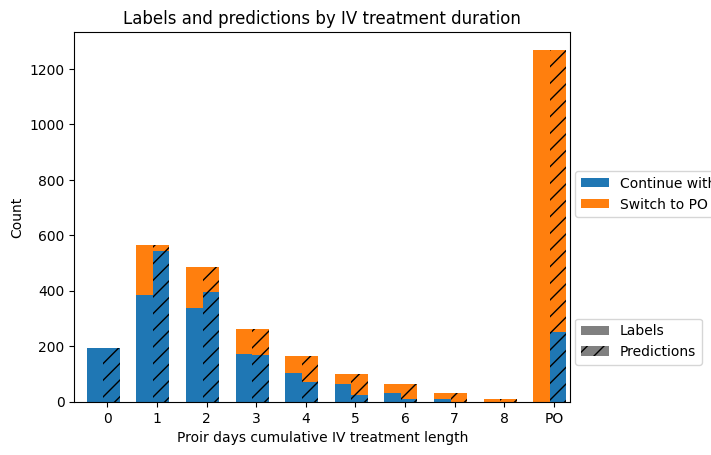

In [118]:
plot_clustered_stacked([df1, df2],["Labels", "Predictions"], title="Labels and predictions by IV treatment duration",  H="//")


<Axes: title={'center': 'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

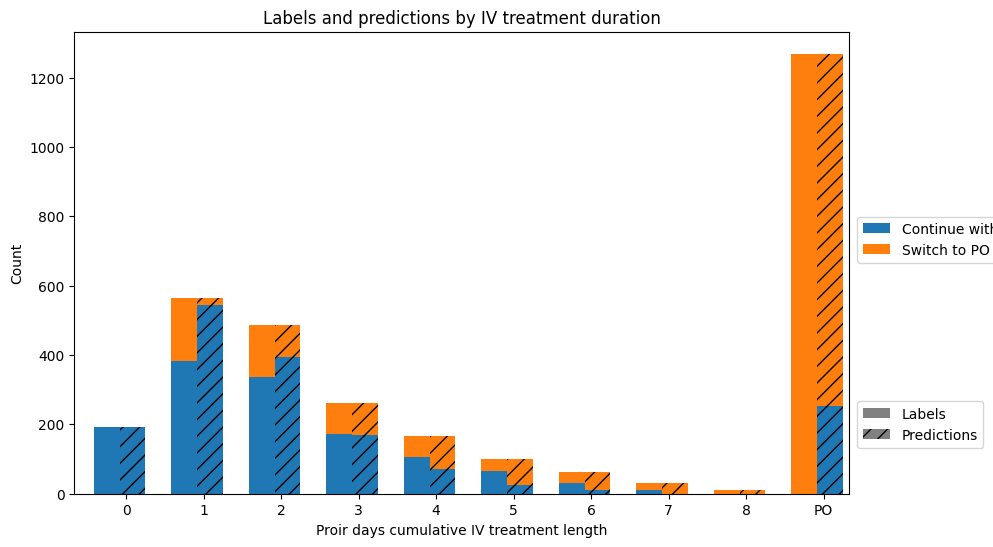

In [120]:
plot_clustered_stacked([df1, df2],["Labels", "Predictions"], title="Labels and predictions by IV treatment duration",  H="//")


24 & 48 hours version

In [85]:
# Get iv_treatment_length
icare_df_preprocessed_2 = icare_df_preprocessed.rename(columns={'SPELL_IDENTIFIER':'stay_id'})
icare_df_preprocessed_2 = icare_df_preprocessed_2.drop(columns=columns_to_drop)
icare_df_preprocessed_2 = icare_df_preprocessed_2.drop(columns=['date', 'ROUTE', 'iv_treatment_length'])

# Merge 
test_data = pd.merge(test_data, icare_df_preprocessed_2)

In [87]:
def label_race (row):
    if row['24_hour_flag'] == 1 :
        return '24'
    if row['48_hour_flag'] == 1 :
        return '48'
    else:
        return 'Other'

test_data['flag'] = test_data.apply(lambda row: label_race(row), axis=1)
test_data.drop(columns=['24_hour_flag', '48_hour_flag'], inplace=True)

In [88]:
treatment_length_df = pd.DataFrame()

for i in test_data.flag.unique():
    print(i)
    temp_test_data = test_data[test_data['flag'] == i]
    temp_test_data = temp_test_data.drop(columns=['flag'])
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])
    
    # Split up dfs
    vitals_test_data = temp_test_data.iloc[:,2:255]
    demographics_test_data = temp_test_data.iloc[:,255:267]
    comorbidity_test_data = temp_test_data.iloc[:, 267:]

    # Get labels
    test_labels = temp_test_data[['po_flag']]

    # Preprocess comorbidity data
    print('Working on set_transformer_processing_fun...')
    comorbidity_test_data, comorbidity_test_mask = set_transformer_processing_fun(comorbidity_test_data, embedding)
    print('Done!')

    test_dataset = MultiInputDataset([vitals_test_data, demographics_test_data], test_labels, comorbidity_test_data, comorbidity_test_mask)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)#, collate_fn=test_dataset.collate_fn_padd)


    test_loss, test_auroc, test_predictions, test_labels_out = evaluate(model, test_dataloader, criterion)

    new_test_predictions = final_threshold_fun(test_predictions)

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    prediction_values, prediction_counts = np.unique(new_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(prediction_values)):
        if prediction_values[x] == 0:
            prediction_0 = prediction_counts[x]
        elif prediction_values[x] == 1:
            prediction_1 = prediction_counts[x]

    # Lower bound
    test_accuracy2 = accuracy_score(test_labels, new_test_predictions)
    test_balanced_accuracy = balanced_accuracy_score(test_labels, new_test_predictions)
    test_recall = recall_score(test_labels, new_test_predictions)
    test_precision = precision_score(test_labels, new_test_predictions)
    test_f1 = f1_score(test_labels, new_test_predictions)
    test_auprc = average_precision_score(test_labels, new_test_predictions)
    test_cm = confusion_matrix(test_labels, new_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['flag', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr']
treatment_length_df.sort_values(by=['flag'], inplace=True)
# Set to string
treatment_length_df['flag']= treatment_length_df['flag'].astype(str)
# Rename
treatment_length_df.rename(columns={'flag': 'Prediction timeframe', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

24
Working on set_transformer_processing_fun...
Done!
48
Working on set_transformer_processing_fun...
Done!
Other
Working on set_transformer_processing_fun...
Done!


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


In [89]:
treatment_length_df

,Prediction timeframe,Continue with IV,Switch to PO,prediction_0,prediction_1,auroc,balanced_accuracy,accuracy,recall,precision,f1,auprc,cm,tpr,fpr
0,24,440,133,573,0,0.500000,0.500000,0.767888,0.000000,0.000000,0.000000,0.232112,"[[440, 0], [133, 0]]",0.000000,0.000000
1,48,312,199,456,55,0.580966,0.551773,0.636008,0.170854,0.618182,0.267717,0.428515,"[[291, 21], [165, 34]]",0.170854,0.067308
2,Other,546,1518,633,1431,0.784916,0.689944,0.738857,0.793808,0.842068,0.817226,0.820088,"[[320, 226], [313, 1205]]",0.793808,0.413919


In [90]:
df1_2 = treatment_length_df[['Prediction timeframe', 'Continue with IV', 'Switch to PO']].set_index(['Prediction timeframe'])
df2_2 = treatment_length_df[['Prediction timeframe', 'prediction_0', 'prediction_1']].set_index(['Prediction timeframe'])

<Axes: title={'center': 'Labels and predictions by timeframes'}, xlabel='Prediction timeframe', ylabel='Count'>

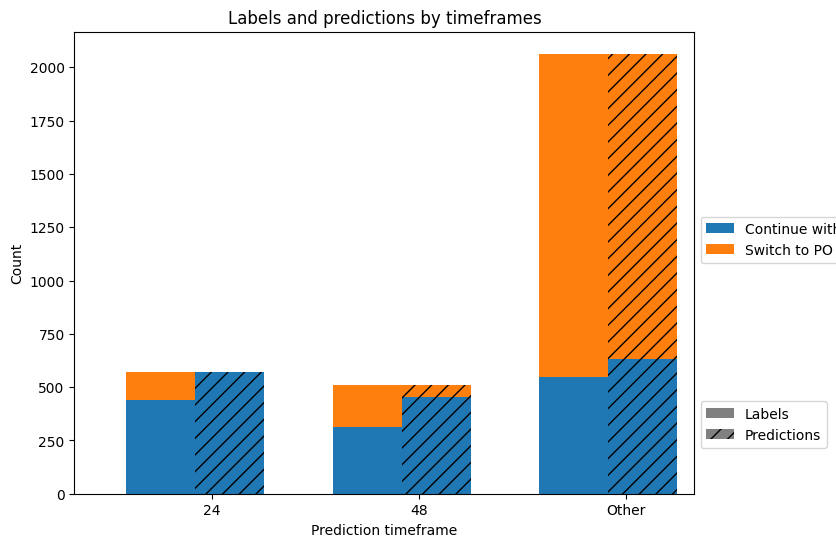

In [123]:
plot_clustered_stacked([df1_2, df2_2],["Labels", "Predictions"], title="Labels and predictions by timeframes",  H="//",  figsize=(8, 6), fontsize=None)

# Label distribution

In [ ]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

In [124]:
# Group mimic
grouped_mimic = icare_df_preprocessed.groupby('iv_treatment_length').po_flag.value_counts()
grouped_mimic2 = pd.pivot(pd.DataFrame(grouped_mimic).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_mimic2 = grouped_mimic2.droplevel('po_flag', axis=1)
grouped_mimic2.reset_index(inplace=True)
grouped_mimic2.columns = ['iv_treatment_length', 'label_0', 'label_1']
# Set to string
grouped_mimic2['iv_treatment_length']= grouped_mimic2['iv_treatment_length'].astype(str)
# Change 999
grouped_mimic2['iv_treatment_length'] = grouped_mimic2['iv_treatment_length'].replace(['999'], 'PO')
grouped_mimic2.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length'}, inplace=True)
# Change to %
grouped_mimic2.fillna(0, inplace=True)
grouped_mimic2['Continue with IV'] = grouped_mimic2['label_0']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100
grouped_mimic2['Switch to PO'] = grouped_mimic2['label_1']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100

In [125]:
def plot_clustered_stacked_2(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col):
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col))    
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    axe.set_ylabel('Percentage')
    axe.set_ylim(0, 100)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    
    return axe

<Axes: title={'center': 'ICHT labels by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Percentage'>

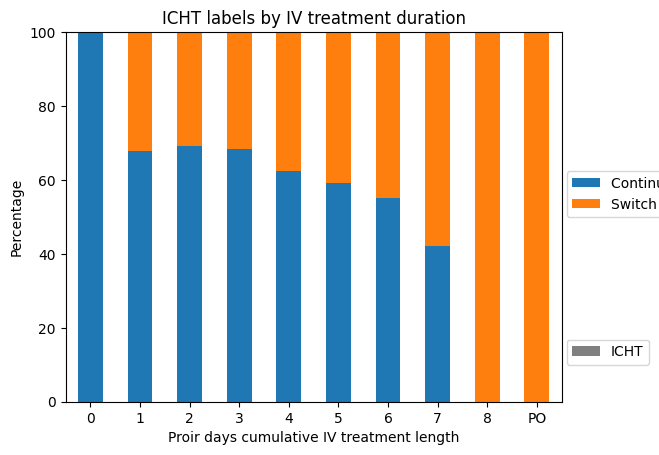

In [126]:
df1 = grouped_mimic2[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
plot_clustered_stacked_2([df1],["ICHT"], title="ICHT labels by IV treatment duration",  H="/", )

In [127]:
def label_race (row):
    if row['24_hour_flag'] == 1 :
        return '24'
    if row['48_hour_flag'] == 1 :
        return '48'
    else:
        return 'Other'

icare_df_preprocessed['flag'] = icare_df_preprocessed.apply(lambda row: label_race(row), axis=1)
icare_df_preprocessed.drop(columns=['24_hour_flag', '48_hour_flag'], inplace=True)

In [129]:
# Group mimic
grouped_mimic = icare_df_preprocessed.groupby('flag').po_flag.value_counts()
grouped_mimic2 = pd.pivot(pd.DataFrame(grouped_mimic).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_mimic2 = grouped_mimic2.droplevel('po_flag', axis=1)
grouped_mimic2.reset_index(inplace=True)
grouped_mimic2.columns = ['flag', 'label_0', 'label_1']
# Set to string
grouped_mimic2['flag']= grouped_mimic2['flag'].astype(str)
# Change 999
grouped_mimic2.rename(columns={'flag': 'Prediction timeframe'}, inplace=True)
# Change to %
grouped_mimic2.fillna(0, inplace=True)
grouped_mimic2['Continue with IV'] = grouped_mimic2['label_0']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100
grouped_mimic2['Switch to PO'] = grouped_mimic2['label_1']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100

<Axes: title={'center': 'ICHT labels by prediction timeframe'}, xlabel='Prediction timeframe', ylabel='Percentage'>

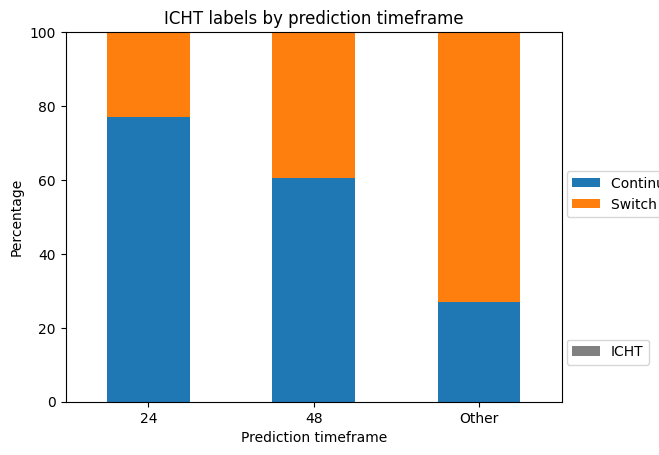

In [130]:
df1 = grouped_mimic2[['Prediction timeframe', 'Continue with IV', 'Switch to PO']].set_index(['Prediction timeframe'])
plot_clustered_stacked_2([df1],["ICHT"], title="ICHT labels by prediction timeframe",  H="/", )

# Spectrum

In [131]:
# Import
path = r'switch_data/antibiotics.csv'
antibiotics_df = pd.read_csv(path)

In [ ]:
# Filter
antibiotics_df = antibiotics_df[antibiotics_df['SPELL_IDENTIFIER'].isin(icare_df_preprocessed['SPELL_IDENTIFIER']).to_list()]
antibiotics_df

In [135]:
# Create df with column for iv and po
filtered_antibiotics_iv = antibiotics_df[antibiotics_df['ROUTE'] == 'IV']
filtered_antibiotics_po = antibiotics_df[antibiotics_df['ROUTE'] =='PO']
filtered_antibiotics_iv.rename(columns={'antibiotics':'iv_antibiotics'}, inplace=True)
filtered_antibiotics_po.rename(columns={'antibiotics':'po_antibiotics'}, inplace=True)
filtered_antibiotics_iv.drop(columns=['ADMINISTRATION_DATETIME', 'ROUTE'], inplace=True)
filtered_antibiotics_po.drop(columns=['ADMINISTRATION_DATETIME', 'ROUTE'], inplace=True)
filtered_antibiotics_df2 = pd.merge(filtered_antibiotics_iv, filtered_antibiotics_po, on=['SPELL_IDENTIFIER'])

In [136]:
# Import
path = r'switch_data/ASI.csv'
asi_df = pd.read_csv(path)
ASI_list = asi_df['Short Drug'].to_list()
ASI2 = asi_df.drop(columns=['Drug', 'Antibiotic Spectrum Index']).set_index('Short Drug')

cumcount = []
cumcount2 = []

for x in range(len(filtered_antibiotics_df2)):
    iv_antibiotic_list = []
    po_antibiotic_list = []
    iv_antibiotic_list = [string for string in ASI_list if string in filtered_antibiotics_df2.loc[x]['po_antibiotics'].lower()]
    iv_sub_df = ASI2.loc[iv_antibiotic_list]
    iv_total_df = iv_sub_df.any(axis=0)
    iv_asi_score = iv_total_df.sum()
    cumcount.append(iv_asi_score)
    po_antibiotic_list = [string for string in ASI_list if string in filtered_antibiotics_df2.loc[x]['iv_antibiotics'].lower()]
    po_sub_df = ASI2.loc[po_antibiotic_list]
    po_total_df = po_sub_df.any(axis=0)
    po_asi_score = po_total_df.sum()
    cumcount2.append(po_asi_score)

filtered_antibiotics_df2['iv_asi'] = cumcount
filtered_antibiotics_df2['po_asi'] = cumcount2

# % Change
filtered_antibiotics_df2['%_change_asi'] = (filtered_antibiotics_df2.po_asi - filtered_antibiotics_df2.iv_asi) / filtered_antibiotics_df2.iv_asi * 100
# Decrease
filtered_antibiotics_df2['decrease_asi'] = np.where(filtered_antibiotics_df2['po_asi'] < filtered_antibiotics_df2['iv_asi'], True, False)

# Mean iv_asi
print('Mean iv_asi:', filtered_antibiotics_df2['iv_asi'].mean())
print('STD iv_asi:', filtered_antibiotics_df2['iv_asi'].std())
# Mean po_asi
print('Mean po_asi:', filtered_antibiotics_df2['po_asi'].mean())
print('STD po_asi:', filtered_antibiotics_df2['po_asi'].std())
# Mean % ASI change
print('Mean % ASI change:', filtered_antibiotics_df2['%_change_asi'].mean())
print('STD % ASI change:', filtered_antibiotics_df2['%_change_asi'].std())
# Percentage decreasing ASI
print('Percentage who decrease ASI:', (len(filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True])/len(filtered_antibiotics_df2))*100)
#Mean iv_asi for those who decrease
print('Mean iv_asi for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['iv_asi'].mean())
print('STD iv_asi for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['iv_asi'].std())
# Mean po_asi for those who decrease
print('Mean po_asi for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['po_asi'].mean())
print('STD po_asi for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['po_asi'].std())
# Mean % ASI change for those who decrease 
print('Mean % ASI change for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['%_change_asi'].mean())
print('STD % ASI change for those who decrease:', filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True]['%_change_asi'].std())


Mean iv_asi: 3.380926916221034
STD iv_asi: 2.9077134488205796
Mean po_asi: 4.590196078431372
STD po_asi: 2.6239587848928076
Mean % ASI change: inf
STD % ASI change: nan
Percentage who decrease ASI: 22.228163992869877
Mean iv_asi for those who decrease: 6.809141940657578
STD iv_asi for those who decrease: 1.8578227695123513
Mean po_asi for those who decrease: 3.6808340016038494
STD po_asi for those who decrease: 2.3482810100064535
Mean % ASI change for those who decrease: -49.260704767922086
STD % ASI change for those who decrease: 30.444506952223755


In [137]:
# Mean iv_asi
Mean_iv_asi = filtered_antibiotics_df2['iv_asi'].mean()
STD_iv_asi = filtered_antibiotics_df2['iv_asi'].std()
# Mean po_asi
Mean_po_asi = filtered_antibiotics_df2['po_asi'].mean()
STD_po_asi = filtered_antibiotics_df2['po_asi'].std()
# Mean % ASI change
Mean_percentage_ASI_change = filtered_antibiotics_df2['%_change_asi'].mean()
STD_percentage_ASI_change = filtered_antibiotics_df2['%_change_asi'].std()
# Percentage decreasing ASI
Percentage_of_patients_who_decrease_ASI = (len(filtered_antibiotics_df2[filtered_antibiotics_df2['decrease_asi'] == True])/len(filtered_antibiotics_df2))*100

In [138]:
# Create lists for the plot
names = ['Mean IV \n ASI', 'Mean oral \n ASI', 'Patients who \n decrease']
x_pos = np.arange(len(names))
asi_means = [Mean_iv_asi, Mean_po_asi, np.nan]
percentage_means = [np.nan, np.nan, Percentage_of_patients_who_decrease_ASI]
asi_error = [STD_iv_asi, STD_po_asi,np.nan]
percentage_error = [np.nan, np.nan, np.nan]

[Text(0, 0, 'Mean IV \n ASI'),
 Text(1, 0, 'Mean oral \n ASI'),
 Text(2, 0, 'Patients who \n decrease')]

Text(0, 0.5, 'ASI')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'MIMIC dataset antibiotic spectrum index (ASI) results')

(0.0, 14.0)

(0.0, 100.0)

<BarContainer object of 3 artists>

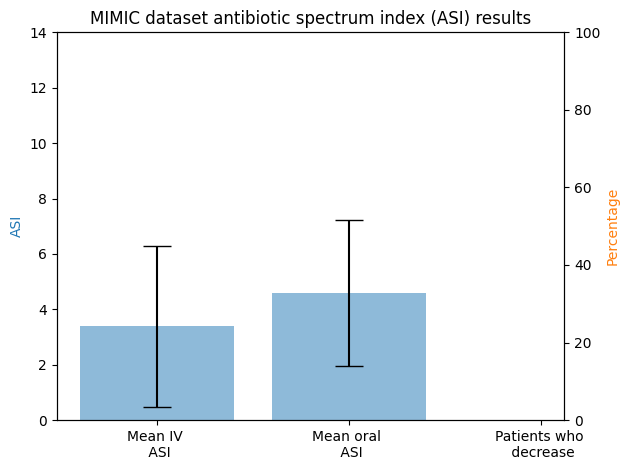

In [139]:
# Build the plot
fig, ax = plt.subplots()

color = 'tab:blue'
color2 = 'tab:orange'

par1 = ax.twinx()
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_ylabel('ASI', color=color)
par1.set_ylabel("Percentage", color=color2)
ax.set_title('MIMIC dataset antibiotic spectrum index (ASI) results')

ax.set_ylim(0, 14)
par1.set_ylim(0, 100)

ax.bar(x_pos, asi_means, yerr=asi_error, color=color, align='center', alpha=0.5, ecolor='black', capsize=10)

# Save the figure and show
plt.tight_layout()
plt.show()

# Type of infection

In [ ]:
import json, snowflake.connector

# establish the connection to snowflake
ctx = snowflake.connector.connect( 
    **json.load(open('/opt/ich/python-snowflake-defaults.json')))
    
# verify and test if connection is working
try: 
    cs = ctx.cursor() 
    cs.execute('SELECT current_version(), current_role(), current_warehouse()')
    print(cs.fetchone())
finally: 
    cs.close()

In [56]:
# Import 
query = '''
SELECT * from ICHT_PROD.ICHT_COVID.EPISODES_DIAGNOSIS
'''
cur = ctx.cursor().execute(query)
diagnosis = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [57]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

In [58]:
# Filter
spell_list = icare_df_preprocessed.SPELL_IDENTIFIER.unique().tolist()
diagnosis = diagnosis[diagnosis['SPELL_IDENTIFIER'].isin(spell_list)]

In [59]:
# Filter by uti
uti_diagnoses = diagnosis[(diagnosis['DIAGNOSIS_DESCRIPTION_ICD'].str.contains("urinary tract infection", case=False)) | \
                                  (diagnosis['DIAGNOSIS_DESCRIPTION_ICD'].str.contains("pyelonephritis", case=False)) | \
                                  (diagnosis['DIAGNOSIS_DESCRIPTION_SNOMED'].str.contains("urinary tract infection", case=False)) | \
                                  (diagnosis['DIAGNOSIS_DESCRIPTION_SNOMED'].str.contains("pyelonephritis", case=False))]
# Filter by pneumonia
pneumonia_diagnoses = diagnosis[(diagnosis['DIAGNOSIS_DESCRIPTION_ICD'].str.contains("pneumonia", case=False)) | \
                                  (diagnosis['DIAGNOSIS_DESCRIPTION_SNOMED'].str.contains("pneumonia", case=False))]

'''# Filter by spesfic sepsis
sepsis_diagnoses = diagnosis[(diagnosis['DIAGNOSIS_CODE_ICD'] == 'A410')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4101')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4102')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A411')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A412')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4181')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P362')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P363')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P3630')| \
                                    (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P3639')]'''
# Filter by sepsis
sepsis_diagnoses = diagnosis[(diagnosis['DIAGNOSIS_DESCRIPTION_ICD'].str.contains("sepsis", case=False)) | \
                                  (diagnosis['DIAGNOSIS_DESCRIPTION_SNOMED'].str.contains("sepsis", case=False))]

# Get stays
uti_stays = uti_diagnoses.SPELL_IDENTIFIER.unique().tolist()
pneumonia_stays = pneumonia_diagnoses.SPELL_IDENTIFIER.unique().tolist()
sepsis_stays = sepsis_diagnoses.SPELL_IDENTIFIER.unique().tolist()

print(len(uti_stays))
print(len(pneumonia_stays))
print(len(sepsis_stays))

"# Filter by spesfic sepsis\nsepsis_diagnoses = diagnosis[(diagnosis['DIAGNOSIS_CODE_ICD'] == 'A410')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4101')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4102')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A411')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A412')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'A4181')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P362')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P363')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P3630')|                                     (diagnosis['DIAGNOSIS_CODE_ICD'] == 'P3639')]"

735
1504
1781


In [62]:
del diagnosis

In [63]:
print(len(uti_stays))
print(len(pneumonia_stays))
print(len(sepsis_stays))

735
1504
1781


In [32]:
# Function to train and eval model 
def diagnosis_cv_run_fun(data, model, filter_list):

    overall_best_test_auroc = 0

    actual_test_auroc_results = []

    test_auroc_results = []
    test_accuracy_results = []
    test_balanced_accuracy_results = []
    test_recall_results = []
    test_precision_results = []
    test_f1_results = []
    test_auprc_results = []
    test_cm_results = []
    test_true_positive_rate_results = []
    test_fasle_positive_rate_results = []

    final_threshold = 0

    # Define batch size 
    batch_size = 512

    # Define optimizer and learning_rate
    learning_rate = 0.0001
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    # Define epochs and clip
    N_EPOCHS = 10
    CLIP = 1

    # Split into folds
    split_generator = cv_data_fun(data)

    # Iterate through folds
    for x in range(N_EPOCHS): # Note this only works as number of splits and epocs are the same
        train_idx, val_idx, test_idx = next(split_generator)

        # Get train val and test
        train_data = data.loc[train_idx]
        valid_data = data.loc[val_idx]
        test_data = data.loc[test_idx]

        # Filter test for only those diagnosis we care about
        test_data = test_data[test_data['stay_id'].isin(filter_list)]

        #Apply smote - crashes with these features
        #train_data = smote_fun(train_data)

        # Split up dfs
        vitals_train_data = train_data.iloc[:,2:255]
        demographics_train_data = train_data.iloc[:,255:267]
        comorbidity_train_data = train_data.iloc[:, 267:]

        vitals_valid_data = valid_data.iloc[:,2:255]
        demographics_valid_data = valid_data.iloc[:,255:267]
        comorbidity_valid_data = valid_data.iloc[:, 267:]

        vitals_test_data = test_data.iloc[:,2:255]
        demographics_test_data = test_data.iloc[:,255:267]
        comorbidity_test_data = test_data.iloc[:, 267:]

        # Initializing the weights of our model each fold
        model.apply(init_weights)

        # Get labels
        train_labels = train_data[['po_flag']]
        valid_labels = valid_data[['po_flag']]
        test_labels = test_data[['po_flag']]

        # Preprocess comorbidity data
        print('Working on set_transformer_processing_fun...')
        comorbidity_train_data, comorbidity_train_mask = set_transformer_processing_fun(comorbidity_train_data, embedding)
        comorbidity_valid_data, comorbidity_valid_mask = set_transformer_processing_fun(comorbidity_valid_data, embedding)
        comorbidity_test_data, comorbidity_test_mask = set_transformer_processing_fun(comorbidity_test_data, embedding)
        print('Done!')

        # Define dataloaders
        train_dataset =  MultiInputDataset([vitals_train_data, demographics_train_data], train_labels, comorbidity_train_data, comorbidity_train_mask)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

        valid_dataset = MultiInputDataset([vitals_valid_data, demographics_valid_data], valid_labels, comorbidity_valid_data, comorbidity_valid_mask)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

        test_dataset = MultiInputDataset([vitals_test_data, demographics_test_data], test_labels, comorbidity_test_data, comorbidity_test_mask)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

        # Run
        best_valid_loss = float('inf')
        best_valid_auroc = 0

        optimal_threshold = 0

        for epoch in range(N_EPOCHS):

            start_time = time.time()

            train_loss, train_auroc, train_predictions, train_labels_out = train(model, train_dataloader, optimizer, criterion, CLIP)

            valid_loss, valid_auroc, valid_predictions, valid_labels_out = evaluate(model, valid_dataloader, criterion)

            end_time = time.time()
            
            fpr, tpr, thresholds = roc_curve(valid_labels_out, valid_predictions)
            optimal_idx = np.argmax(tpr - fpr)
            current_threshold = thresholds[optimal_idx]

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print('Train AUROC:', train_auroc)
            print('Valid AUROC:', valid_auroc)
            print(train_predictions)
            print(train_labels_out)
            print('Train loss:', train_loss)
            print('Valid loss:', valid_loss)
            print(current_threshold)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                print('BEST VALID LOSS')

            if valid_auroc > best_valid_auroc:
                best_valid_auroc = valid_auroc
                print('UPDATED BEST INTERMEDIATE MODEL')
                torch.save(model.state_dict(), f'chronic_switch_model_intermediate_diagnosis.pt')
                optimal_threshold = current_threshold

        # -----------------------------
        # Evaluate best model on test set
        # -----------------------------

        model.load_state_dict(torch.load(f'chronic_switch_model_intermediate_diagnosis.pt'))

        test_loss, test_auroc, test_predictions, test_labels_out = evaluate(model, test_dataloader, criterion)

        print('Test AUROC result:', test_auroc)
        
        new_test_predictions = new_threshold_fun(test_predictions, optimal_threshold)

        test_accuracy = accuracy_score(test_labels_out, new_test_predictions)
        test_balanced_accuracy = balanced_accuracy_score(test_labels_out, new_test_predictions)
        test_recall = recall_score(test_labels_out, new_test_predictions)
        test_precision = precision_score(test_labels_out, new_test_predictions)
        test_f1 = f1_score(test_labels_out, new_test_predictions)
        test_auprc = average_precision_score(test_labels_out, test_predictions)
        test_cm = confusion_matrix(test_labels_out, new_test_predictions)
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
        
        actual_test_auroc_results.append(test_auroc)
        
        test_auroc_results.append(test_auroc)
        test_accuracy_results.append(test_accuracy)
        test_balanced_accuracy_results.append(test_balanced_accuracy)
        test_recall_results.append(test_recall)
        test_precision_results.append(test_precision)
        test_f1_results.append(test_f1)
        test_auprc_results.append(test_auprc)
        test_cm_results.append(test_cm)
        test_true_positive_rate_results.append(test_true_positive_rate)
        test_fasle_positive_rate_results.append(test_false_positive_rate)

    test_results = [test_auroc_results, test_accuracy_results,
        test_balanced_accuracy_results,
        test_recall_results,
        test_precision_results,
        test_f1_results,
        test_auprc_results,
        test_cm_results,
        test_true_positive_rate_results,
        test_fasle_positive_rate_results
        ]
    
    return test_results, actual_test_auroc_results, final_threshold

In [27]:
# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [64]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [66]:
pneumonia_test_results, pneumonia_actual_test_auroc_results, pneumonia_final_threshold = diagnosis_cv_run_fun(model_data, model, pneumonia_stays)

/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  

Working on set_transformer_processing_fun...
Done!
Train AUROC: 0.7281933559500635
Valid AUROC: 0.7595597837001802
[0.5736541 0.5       0.6526704 ... 0.8397096 0.5       0.5      ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5952540314197541
Valid loss: 0.5762601750237601
0.50860393
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7451327406547285
Valid AUROC: 0.7909062159114868
[0.5       0.5       0.7387343 ... 0.8043113 0.5       0.5      ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5754907763004303
Valid loss: 0.5643541898046222
0.60242075
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7562599823376857
Valid AUROC: 0.7945749628541978
[0.5        0.5        0.9160872  ... 0.83982456 0.5        0.5       ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5668838667869568
Valid loss: 0.5575987781797137
0.58973885
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7610374277050135
Valid AUROC: 0.7900585082845764
[0.5      0.5      0.805607 ... 0.5      0.5      0.5 

In [67]:
pneumonia_actual_test_auroc_results
pneumonia_final_threshold

[0.8346082949308756,
 0.8001819953306247,
 0.7915861368624497,
 0.7886005803696412,
 0.8020617283950616,
 0.7923244389862677,
 0.8122085301062573,
 0.7486532418392868,
 0.7745229244114002,
 0.8028592927012791]

0

In [68]:
# Save 
with open("pneumonia_cv_chronic_switch_test_results", "wb") as fp:   #Pickling
    pickle.dump(pneumonia_test_results, fp)

In [69]:
analyze_results_fun(pneumonia_test_results)

mean test_auroc: 0.7947607163933144
std test_auroc: 0.021517355346640375
test_auroc 2.5th percentile: 0.7544739204180123
test_auroc 97.5th percentile: 0.8295683478453365
mean test_accuracy: 0.7209430663409935
std test_accuracy: 0.02469243573392646
test_accuracy 2.5th percentile: 0.6694815668202765
test_accuracy 97.5th percentile: 0.7510678439126952
mean test_balanced_accuracy: 0.7301116095278456
std test_balanced_accuracy: 0.021762136793995617
test_balanced_accuracy 2.5th percentile: 0.6887899137393729
test_balanced_accuracy 97.5th percentile: 0.7605944264069263
mean test_recall: 0.6776117160239636
std test_recall: 0.05534722678112555
test_recall 2.5th percentile: 0.5536285135486889
test_recall 97.5th percentile: 0.7273223381033228
mean test_precision: 0.8183787520586255
std test_precision: 0.024382362752854013
test_precision 2.5th percentile: 0.77905625
test_precision 97.5th percentile: 0.8514123365739189
mean test_f1: 0.739932934816018
std test_f1: 0.03763191575461791
test_f1 2.5th p

In [70]:
sepsis_test_results, sepsis_actual_test_auroc_results, sepsis_final_threshold = diagnosis_cv_run_fun(model_data, model, sepsis_stays)

/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 3/3 [00:01<00:00,  2.11it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 3/3 [00:01<00:00,  2.22it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  

Working on set_transformer_processing_fun...
Done!
Train AUROC: 0.6950722879058139
Valid AUROC: 0.7814701821081815
[0.5043391 0.5       0.5       ... 0.8067422 0.6360695 0.5      ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.6121254944801331
Valid loss: 0.5677178246634347
0.6084497
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7432102133453509
Valid AUROC: 0.7758610201158166
[0.54713154 0.67880684 0.80330044 ... 0.89953524 0.5        0.56977755]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5764546918869019
Valid loss: 0.5639224393027169
0.5713088
BEST VALID LOSS
Train AUROC: 0.7508073133453215
Valid AUROC: 0.802208498159585
[0.5        0.50153697 0.7783672  ... 0.8832424  0.5216739  0.5       ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5698820161819458
Valid loss: 0.5638657893453326
0.71340036
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7593654653933852
Valid AUROC: 0.8104155746536877
[0.5        0.5757977  0.5        ... 0.5        0.59049934 0.65363216]
[0. 0. 0. .

In [ ]:
# Save 
#with open("sepsis_cv_chronic_switch_test_results", "wb") as fp:   #Pickling
#    pickle.dump(sepsis_test_results, fp)

In [18]:
# Load
with open('sepsis_cv_chronic_switch_test_results', 'rb') as f:
    sepsis_test_results = pickle.load(f)

In [20]:
analyze_results_fun(sepsis_test_results)

mean test_auroc: 0.8095139284960622
std test_auroc: 0.013529437781517342
test_auroc 2.5th percentile: 0.7893046516365265
test_auroc 97.5th percentile: 0.8364267226872192
mean test_accuracy: 0.746431068513224
std test_accuracy: 0.0136024663712991
test_accuracy 2.5th percentile: 0.7249372261663768
test_accuracy 97.5th percentile: 0.7708383515925415
mean test_balanced_accuracy: 0.7510976303660024
std test_balanced_accuracy: 0.01318183474281759
test_balanced_accuracy 2.5th percentile: 0.7276261792833661
test_balanced_accuracy 97.5th percentile: 0.7736774906620348
mean test_recall: 0.7116003617326493
std test_recall: 0.026077891200200938
test_recall 2.5th percentile: 0.6665079913180741
test_recall 97.5th percentile: 0.751852700096432
mean test_precision: 0.8075976581483342
std test_precision: 0.02396834526175985
test_precision 2.5th percentile: 0.7633167320428748
test_precision 97.5th percentile: 0.8371279982232751
mean test_f1: 0.7559673083225462
std test_f1: 0.014195973538178062
test_f1 2

In [ ]:
uti_test_results, uti_actual_test_auroc_results, uti_final_threshold = diagnosis_cv_run_fun(model_data, model, uti_stays)

In [ ]:
# Save 
#with open("uti_cv_chronic_switch_test_results", "wb") as fp:   #Pickling
#    pickle.dump(uti_test_results, fp)

In [21]:
# Load
with open('uti_cv_chronic_switch_test_results', 'rb') as f:
    uti_test_results = pickle.load(f)

In [22]:
analyze_results_fun(uti_test_results)

mean test_auroc: 0.8031066059431886
std test_auroc: 0.027938443281141888
test_auroc 2.5th percentile: 0.756808151188022
test_auroc 97.5th percentile: 0.8423909265003009
mean test_accuracy: 0.7223024529416877
std test_accuracy: 0.017710411680584272
test_accuracy 2.5th percentile: 0.6908197650502712
test_accuracy 97.5th percentile: 0.7495339412360689
mean test_balanced_accuracy: 0.7350152510003166
std test_balanced_accuracy: 0.017723902469494707
test_balanced_accuracy 2.5th percentile: 0.7022129816376297
test_balanced_accuracy 97.5th percentile: 0.7576175521697958
mean test_recall: 0.6772688631299217
std test_recall: 0.044444572216346484
test_recall 2.5th percentile: 0.6161141718595384
test_recall 97.5th percentile: 0.7472277716475986
mean test_precision: 0.8329803759667194
std test_precision: 0.0382031356335541
test_precision 2.5th percentile: 0.7832495496627707
test_precision 97.5th percentile: 0.8948313866941486
mean test_f1: 0.7454736856718482
std test_f1: 0.024583503423787886
test_f

# Bad bio

In [23]:
# Import
path = r'switch_data/antibiotics.csv'
antibiotics_df = pd.read_csv(path)

In [25]:
# Define antibiotics with bad bioavailability
pattern = 'Azithromycin|Ciprofloxacin|Cefpodoxime|Clindamycin|Amoxicillin|Clarithromycin|Nitrofurantoin|Ampicillin|Erythromycin|Penicillin|DiCLOXacillin|Tetracycline|Neomycin|Augmentin|flucloxacillin'

In [26]:
# Filter for those patients with bad bioavailability drugs
filtered_antibiotics_df = antibiotics_df[antibiotics_df['ROUTE'] == 'PO']
filtered_antibiotics_df = filtered_antibiotics_df[filtered_antibiotics_df['antibiotics'].str.contains(pattern, case=False, na=False)]
# Define stay list
bad_bio_stay_id_list = filtered_antibiotics_df.SPELL_IDENTIFIER.unique()

In [28]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [37]:
icare_df_preprocessed.SPELL_IDENTIFIER.nunique()

5610

In [29]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [39]:
model_data.stay_id.nunique()

5610

In [30]:
# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Chronic_switch_model(
  (final_layers): Sequential(
    (0): Linear(in_features=268, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
  )
  (vital_model): Initial_vitals_model(
    (layers): Sequential(
      (0): BatchNorm1d(253, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=253, out_features=512, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=128, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (set_transformer): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB0(
          (fc_q): Linear(in_features=160, out_features=160, bias=True)
          (f

The model has 1,126,583 trainable parameters


In [33]:
# Can use diagnosis_cv_run function as just need functionality to filter test set
bad_bio_test_results, bad_bio_actual_test_auroc_results, bad_bio_final_threshold = diagnosis_cv_run_fun(model_data, model, bad_bio_stay_id_list)

/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
/tmp/ipykernel_4116/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch

Working on set_transformer_processing_fun...
Done!
Train AUROC: 0.7282084972158595
Valid AUROC: 0.7919493400422166
[0.5       0.5       0.5       ... 0.7458981 0.5095525 0.5      ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5947360348701477
Valid loss: 0.5651802335466657
0.5924756
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7491536794203698
Valid AUROC: 0.792919339233884
[0.5        0.5590289  0.73691523 ... 0.7553793  0.5        0.59409684]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5737382161617279
Valid loss: 0.5587632570947919
0.63012135
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7564256703021439
Valid AUROC: 0.7970443357963868
[0.5        0.5        0.83671963 ... 0.7959285  0.5373942  0.6495511 ]
[0. 0. 0. ... 0. 1. 1.]
Train loss: 0.5675568413734436
Valid loss: 0.5551360079220363
0.5894195
BEST VALID LOSS
UPDATED BEST INTERMEDIATE MODEL
Train AUROC: 0.7615356896172687
Valid AUROC: 0.8081001599165334
[0.5        0.5        0.8201851  ... 0.8589042  0.

In [34]:
# Save 
with open("bad_bio_cv_chronic_switch_test_results", "wb") as fp:   #Pickling
    pickle.dump(bad_bio_test_results, fp)

In [35]:
analyze_results_fun(bad_bio_test_results)

mean test_auroc: 0.7557939457720296
std test_auroc: 0.08594136418201168
test_auroc 2.5th percentile: 0.5609762605815237
test_auroc 97.5th percentile: 0.8057350510770652
mean test_accuracy: 0.6845771559129034
std test_accuracy: 0.0883127508030187
test_accuracy 2.5th percentile: 0.48134184739170915
test_accuracy 97.5th percentile: 0.7260350183277177
mean test_balanced_accuracy: 0.6987186452388354
std test_balanced_accuracy: 0.06688606390720815
test_balanced_accuracy 2.5th percentile: 0.5464291958041958
test_balanced_accuracy 97.5th percentile: 0.7371465041084755
mean test_recall: 0.6106196345706854
std test_recall: 0.2088635893878391
test_recall 2.5th percentile: 0.12865384615384615
test_recall 97.5th percentile: 0.7308493606847823
mean test_precision: 0.7213708395426932
std test_precision: 0.2415033440656824
test_precision 2.5th percentile: 0.1741097208854668
test_precision 97.5th percentile: 0.8371588634048681
mean test_f1: 0.6598064516129832
std test_f1: 0.22112276800901295
test_f1 2.

# Outcomes

In [140]:
def test_stats(list1, list2):

    # Test if same distribution
    k2, p = stats.mannwhitneyu(list1, list2)
    alpha = 0.05
    print(p)
    if p < alpha:
        print('Different distribution')
    else:
        print(' Same distribution')

In [144]:
# Load model

# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

model.load_state_dict(torch.load('chronic_switch_model.pt'))

print(f'The model has {count_parameters(model):,} trainable parameters')

<All keys matched successfully>

The model has 1,126,583 trainable parameters


In [145]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [146]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [ ]:
import json, snowflake.connector

# establish the connection to snowflake
ctx = snowflake.connector.connect( 
    **json.load(open('/opt/ich/python-snowflake-defaults.json')))
    
# verify and test if connection is working
try: 
    cs = ctx.cursor() 
    cs.execute('SELECT current_version(), current_role(), current_warehouse()')
    print(cs.fetchone())
finally: 
    cs.close()

In [147]:
# Import 
query = '''
SELECT * from ICHT_PROD.ICHT_COVID.EPISODES
'''
cur = ctx.cursor().execute(query)
episodes = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [148]:
# Import 
query = '''
SELECT * from ICHT_PROD.ICHT_COVID.demographic
'''
cur = ctx.cursor().execute(query)
demographic = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [149]:
# Get discharge time
stay_list = icare_df_preprocessed.SPELL_IDENTIFIER.unique().tolist()
episodes2 = episodes[episodes['SPELL_IDENTIFIER'].isin(stay_list)]
episodes2 = episodes2[['SPELL_IDENTIFIER', 'DISCHARGE_DATE_TIME']].drop_duplicates()
episodes2.rename(columns={'SPELL_IDENTIFIER': 'stay_id', 'DISCHARGE_DATE_TIME':'outtime'}, inplace=True)

In [151]:
def los_cv_run_fun(data, icu_stays):

    ### Import LOS ###

    po_los_dict = {}
    iv_los_dict = {}

    # Split into folds
    split_generator = cv_data_fun(data)

    # Iterate through folds
    for x in range(N_EPOCHS):
        train_idx, val_idx, test_idx = next(split_generator)

        # Get train val and test
        train_data = data.loc[train_idx]
        valid_data = data.loc[val_idx]
        test_data = data.loc[test_idx]
        
        test_data = test_data[(test_data['iv_treatment_length'] >= 1) & (test_data['iv_treatment_length'] < 8)]

        for i in test_data.iv_treatment_length.unique():
            temp_data = test_data[(test_data['iv_treatment_length'] == i) & (test_data['po_flag'] == 1)]
            temp_data = pd.merge(temp_data, icu_stays)
            temp_data['date'] = pd.to_datetime(temp_data['date'])
            temp_data['outtime'] = pd.to_datetime(temp_data['outtime'])
            temp_data['remaining_los'] =  (temp_data['outtime'] - temp_data['date']).dt.days
            remaining_los_list = temp_data['remaining_los'].values.tolist()
            
            if x == 0:
                po_los_dict[i] = remaining_los_list
            else:
                new_los_list = po_los_dict[i]
                new_los_list.extend(remaining_los_list)
                po_los_dict[i] = new_los_list
        
        for i in test_data.iv_treatment_length.unique():
            temp_data = test_data[(test_data['iv_treatment_length'] == i) & (test_data['po_flag'] == 0)]
            temp_data = pd.merge(temp_data, icu_stays)
            temp_data['date'] = pd.to_datetime(temp_data['date'])
            temp_data['outtime'] = pd.to_datetime(temp_data['outtime'])
            temp_data['remaining_los'] =  (temp_data['outtime'] - temp_data['date']).dt.days
            remaining_los_list = temp_data['remaining_los'].values.tolist()
            if x == 0:
                iv_los_dict[i] = remaining_los_list
            else:
                new_los_list = iv_los_dict[i]
                new_los_list.extend(remaining_los_list)
                iv_los_dict[i] = new_los_list

        return po_los_dict, iv_los_dict

In [153]:
# Rename
icare_df_preprocessed_2 = icare_df_preprocessed.rename(columns={'SPELL_IDENTIFIER':'stay_id'})

In [154]:
# Run
po_los_dict, iv_los_dict = los_cv_run_fun(icare_df_preprocessed_2, episodes2)

In [155]:
for i in po_los_dict.keys():
    print(i)
    print(mean(po_los_dict[i]))
    print(mean(iv_los_dict[i]))
    test_stats(po_los_dict[i], iv_los_dict[i])

1
3.932926829268293
6.178947368421053
3.6149015675002043e-13
Different distribution
2
3.0597826086956523
6.030959752321982
3.5197832922118626e-23
Different distribution
3
2.9647058823529413
5.788571428571428
5.278304649447711e-11
Different distribution
4
3.1216216216216215
5.735849056603773
7.53305298830694e-09
Different distribution
5
3.0833333333333335
5.633333333333334
0.00011822025825896418
Different distribution
6
4.724137931034483
4.702702702702703
0.31891233791178597
 Same distribution
7
1.9545454545454546
5.444444444444445
0.0019320212257584975
Different distribution


In [156]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [158]:
# See if results are same with outliers removed
po_means = []
po_std = []
iv_means = []
iv_std = []
for i in po_los_dict.keys():
    print(i)
    po_los_dict2 = reject_outliers(np.array(po_los_dict[i]))
    iv_los_dict2 = reject_outliers(np.array(iv_los_dict[i]))

    print(mean(po_los_dict2))
    po_means.append(mean(po_los_dict2))
    po_std.append(std(po_los_dict2))
    print(mean(iv_los_dict2))
    iv_means.append(mean(iv_los_dict2))
    iv_std.append(std(iv_los_dict2))

    test_stats(po_los_dict2, iv_los_dict2)

1
3.2625
5.292817679558011
4.30546467398865e-13
Different distribution
2
2.1040462427745665
5.1237785016286646
8.39323685819308e-28
Different distribution
3
2.111111111111111
4.982035928143713
1.9176060758276937e-12
Different distribution
4
2.072463768115942
4.910891089108911
5.895619891750137e-11
Different distribution
5
2.2045454545454546
4.607142857142857
1.1061039950292758e-05
Different distribution
6
3.5555555555555554
3.7058823529411766
0.28401680045512734
 Same distribution
7
1.3
4.823529411764706
0.0005780910406318757
Different distribution


Text(0, 0.5, 'Mean remaining LOS')

Text(0.5, 1.0, 'Remaining LOS by IV treatment duration')

Text(0.5, 0, 'Prior days cumulative IV treatment length')

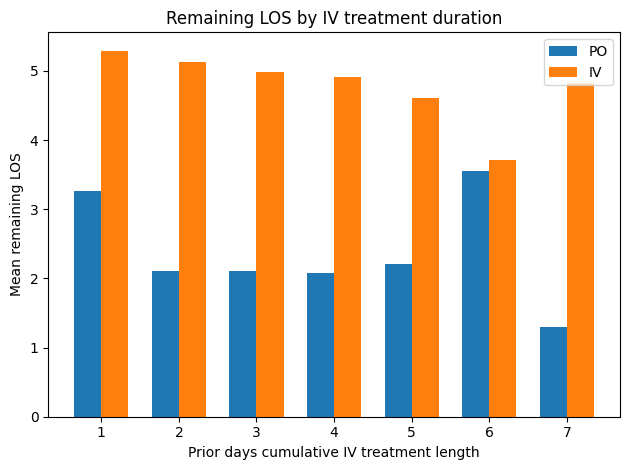

In [161]:
labels = ['1', '2', '3', '4', '5', '6', '7']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, po_means, width, label='PO')
rects2 = ax.bar(x + width/2, iv_means, width, label='IV')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean remaining LOS')
ax.set_title('Remaining LOS by IV treatment duration')
ax.set_xlabel('Prior days cumulative IV treatment length')

ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [162]:
def los_cv_run_fun2(data, icu_stays):

    ### Import LOS ###

    po_los_dict = {}
    iv_los_dict = {}

    # Split into folds
    split_generator = cv_data_fun(data)

    # Iterate through folds
    for x in range(N_EPOCHS):
        train_idx, val_idx, test_idx = next(split_generator)

        # Get train val and test
        train_data = data.loc[train_idx]
        valid_data = data.loc[val_idx]
        test_data = data.loc[test_idx]

        for i in test_data.flag.unique():
            temp_data = test_data[(test_data['flag'] == i) & (test_data['po_flag'] == 1)]
            temp_data = pd.merge(temp_data, icu_stays)
            temp_data['date'] = pd.to_datetime(temp_data['date'])
            temp_data['outtime'] = pd.to_datetime(temp_data['outtime'])
            temp_data['remaining_los'] =  (temp_data['outtime'] - temp_data['date']).dt.days
            remaining_los_list = temp_data['remaining_los'].values.tolist()
            
            if x == 0:
                po_los_dict[i] = remaining_los_list
            else:
                new_los_list = po_los_dict[i]
                new_los_list.extend(remaining_los_list)
                po_los_dict[i] = new_los_list
        
        for i in test_data.flag.unique():
            temp_data = test_data[(test_data['flag'] == i) & (test_data['po_flag'] == 0)]
            temp_data = pd.merge(temp_data, icu_stays)
            temp_data['date'] = pd.to_datetime(temp_data['date'])
            temp_data['outtime'] = pd.to_datetime(temp_data['outtime'])
            temp_data['remaining_los'] =  (temp_data['outtime'] - temp_data['date']).dt.days
            remaining_los_list = temp_data['remaining_los'].values.tolist()
            if x == 0:
                iv_los_dict[i] = remaining_los_list
            else:
                new_los_list = iv_los_dict[i]
                new_los_list.extend(remaining_los_list)
                iv_los_dict[i] = new_los_list

        return po_los_dict, iv_los_dict

In [164]:
def label_race (row):
    if row['24_hour_flag'] == 1 :
        return '24'
    if row['48_hour_flag'] == 1 :
        return '48'
    else:
        return 'Other'

icare_df_preprocessed_2['flag'] = icare_df_preprocessed_2.apply(lambda row: label_race(row), axis=1)

In [166]:
# Run
po_los_dict, iv_los_dict = los_cv_run_fun2(icare_df_preprocessed_2, episodes2)

In [167]:
for i in po_los_dict.keys():
    print(i)
    print(mean(po_los_dict[i]))
    print(mean(iv_los_dict[i]))
    test_stats(po_los_dict[i], iv_los_dict[i])

24
3.7327586206896552
6.48729792147806
4.748851980315718e-16
Different distribution
48
4.17
5.927392739273928
1.3062096228515763e-10
Different distribution
Other
4.190352020860495
5.672597864768683
8.417013016956244e-25
Different distribution


In [168]:
# See if results are same with outliers removed
po_means = []
po_std = []
iv_means = []
iv_std = []
for i in po_los_dict.keys():
    print(i)
    po_los_dict2 = reject_outliers(np.array(po_los_dict[i]))
    iv_los_dict2 = reject_outliers(np.array(iv_los_dict[i]))

    print(mean(po_los_dict2))
    po_means.append(mean(po_los_dict2))
    po_std.append(std(po_los_dict2))
    print(mean(iv_los_dict2))
    iv_means.append(mean(iv_los_dict2))
    iv_std.append(std(iv_los_dict2))

    test_stats(po_los_dict2, iv_los_dict2)

24
2.893805309734513
5.614077669902913
1.8309947449483803e-16
Different distribution
48
3.4871794871794872
5.055555555555555
2.5043050376283927e-10
Different distribution
Other
3.377397260273973
4.796992481203008
1.0466136418907882e-27
Different distribution


Text(0, 0.5, 'Mean remaining LOS')

Text(0.5, 1.0, 'Remaining LOS by IV treatment duration')

Text(0.5, 0, 'Prior days cumulative IV treatment length')

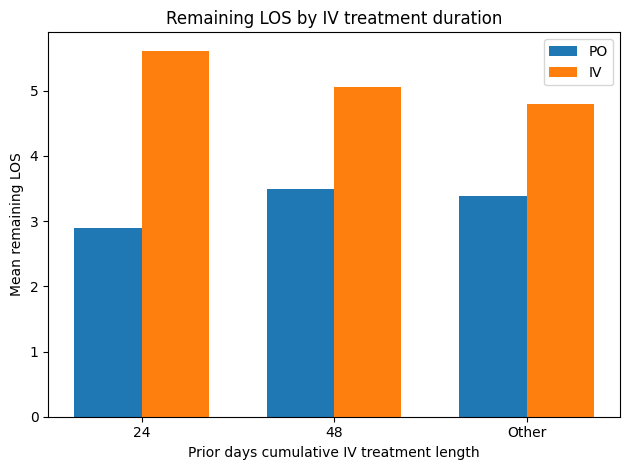

In [169]:
labels = ['24', '48', 'Other']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, po_means, width, label='PO')
rects2 = ax.bar(x + width/2, iv_means, width, label='IV')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean remaining LOS')
ax.set_title('Remaining LOS by IV treatment duration')
ax.set_xlabel('Prior days cumulative IV treatment length')

ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

# Early, late , agree

In [17]:
import json, snowflake.connector

# establish the connection to snowflake
ctx = snowflake.connector.connect( 
    **json.load(open('/opt/ich/python-snowflake-defaults.json')))
    
# verify and test if connection is working
try: 
    cs = ctx.cursor() 
    cs.execute('SELECT current_version(), current_role(), current_warehouse()')
    print(cs.fetchone())
finally: 
    cs.close()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/be00e2c6-806c-45f8-84c3-3fc99f64b8d3/saml2?SAMLRequest=pZNdb9owFIb%2FSuRdJ3E%2BCMEiVLSsK1pbGKTVtLvgOGDh2MHHIW1%2F%2FUwoUnfR3uzOsp9jPz6vPb56qYVzZBq4khkKPIwcJqkqudxm6Cm%2FdVPkgClkWQglWYZeGaCryRiKWjRk2pqdXLFDy8A4diMJpF%2FIUKslUQVwILKoGRBDyXr6cE9CD5NGK6OoEuhDydcVBQDTxhpeSkrgVm9nTEN8v%2Bs6r4s8pbd%2BiDH28ci31An5duFf7J0%2B4QMfxyfeEhZfvrtdc3luwVdamzME5C7Pl%2B5ysc6RM72o3igJbc30mukjp%2BxpdX8WAGsAEA3TNPHavQvK9tBrND8Whgku9x5I1VWi2DOq6qY19gDPjvyKlb5QW257MJ9lqNnz8vnAsZC%2FVsmQXS9CdRi%2B3SW79O374OdjfvtjudiA%2Bt0cusVCP1DkPF9CDk8hzwFaNpenaI2dwmHs4sgN0jxIyCAiYeSF8fAPcmY2Wi4L01de%2FHsPr%2BZUK1CVUdKKs95ywzBmIU3cFCfUjQdV6qYxjdyooqNRlcSbtIz8U%2BAhOj8i0ovoyX%2B0Zux%2F3Oj9aT7atOazpRKcvjq3SteF%2BTzMwAv6GV66VY8SVhdcTMtSMwAbqhCqu9HMem

('8.10.2', 'ICHT_RG_COVOAM_22016_PROD', 'ICHT_WH_COVOAM_22016_PROD')


True

In [18]:
# Import 
query = '''
SELECT * from ICHT_PROD.ICHT_COVID.EPISODES
'''
cur = ctx.cursor().execute(query)
episodes = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [19]:
# Import 
query = '''
SELECT * from ICHT_PROD.ICHT_COVID.demographic
'''
cur = ctx.cursor().execute(query)
demographic = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [22]:
# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Chronic_switch_model(
  (final_layers): Sequential(
    (0): Linear(in_features=268, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
  )
  (vital_model): Initial_vitals_model(
    (layers): Sequential(
      (0): BatchNorm1d(253, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=253, out_features=512, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=128, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (set_transformer): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB0(
          (fc_q): Linear(in_features=160, out_features=160, bias=True)
          (f

The model has 1,126,583 trainable parameters


In [23]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [24]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['ROUTE', '24_hour_flag', '48_hour_flag'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

In [28]:
# Get discharge time and LOS and mortality 
stay_list = icare_df_preprocessed.SPELL_IDENTIFIER.unique().tolist()
episodes2 = episodes[episodes['SPELL_IDENTIFIER'].isin(stay_list)]
episodes2 = episodes2[['SUBJECT', 'SPELL_IDENTIFIER',  'ADMISSION_DATE_TIME', 'DISCHARGE_DATE_TIME']].drop_duplicates()
episodes2.rename(columns={'SPELL_IDENTIFIER': 'stay_id', 'ADMISSION_DATE_TIME': 'intime', 'DISCHARGE_DATE_TIME':'outtime'}, inplace=True)
# Create los column 
episodes2['intime'] = pd.to_datetime(episodes2['intime'])
episodes2['outtime'] = pd.to_datetime(episodes2['outtime'])
episodes2['los'] =  (episodes2['outtime'] - episodes2['intime'])
# Convert to float from time delta
episodes2['los'] = episodes2['los'] / datetime.timedelta(days=1)
# Merge 
episodes2 = episodes2.merge(demographic[['SUBJECT', 'DEATH_DATE']])
# Create death column
episodes2['hospital_expire_flag'] = np.where(episodes2.DEATH_DATE <= episodes2.outtime, 1, 0)

In [30]:
# For only having one positive switch day per stay
def lb_predicted_switch_day_fun(data):
    # Convert to datetime
    data['date'] = pd.to_datetime(data['date'])

    # iv_treatment_length
    cumcount = []
    count = 0
    pos = -1
    flag = 0

    for x in range(len(data)):
        pos += 1
        if pos == len(data) - 1:
            cumcount.append(count) # add count to last one
            break # end
        elif pos == 0:
            cumcount.append(count) # add 0 to first one
            count += 1
        elif data.iloc[x]['stay_id'] == data.iloc[x+1]['stay_id']:
            if data.iloc[x]['lb_prediction'] == 0:
                cumcount.append(count)
                count += 1
            elif flag == 1:
                cumcount.append(999)
                count = 0
                flag = 1
            elif data.iloc[x]['stay_id'] != data.iloc[x-1]['stay_id']:
                if data.iloc[x]['lb_prediction'] == 1:
                    cumcount.append(count)
                    count += 1
                else:
                    cumcount.append(999)
                    count = 0
            else:
                cumcount.append(count)
                count = 0
                flag = 1
        else:
            if data.iloc[x]['lb_prediction'] == 0:
                cumcount.append(count)
                count = 0
                flag = 0
            elif flag == 1:
                cumcount.append(999)
                count = 0
                flag = 0
            else:
                cumcount.append(count)
                count = 0
                flag = 0

    print(len(cumcount))

    data['lb_predicted_switch_day'] = cumcount
    
    return data

In [32]:
# Function to split data so even distribution between val and test
def cv_data_fun2(data, n_cv=10):
    X = data.iloc[:, 4:]
    y = data['po_flag']
    g = StratifiedKFold3(n_cv).split(X,y)
    return g

In [ ]:
# Split into folds
split_generator = cv_data_fun2(model_data)

# Iterate through folds
for x in range(10):
    train_idx, val_idx, test_idx = next(split_generator)

    # Get train val and test
    train_data = model_data.loc[train_idx]
    valid_data = model_data.loc[val_idx]
    test_data = model_data.loc[test_idx]

    # Filter for those who switch
    test_stay_id_list = (test_data.groupby(['stay_id'])['po_flag'].nunique() > 1).where(lambda x : x==True).dropna().reset_index()['stay_id'].unique().tolist()
    filtered_test_data = test_data[test_data['stay_id'].isin(test_stay_id_list)]


    # Find the day they actually switched
    test_switch_day = filtered_test_data[filtered_test_data['po_flag'] == 1].drop_duplicates(subset=['stay_id'], keep='first')
    test_switch_day = test_switch_day[['stay_id', 'iv_treatment_length']]
    test_switch_day.rename(columns={'iv_treatment_length': 'real_switch_day'}, inplace=True)
    test_switch_day.reset_index(drop=True, inplace=True)
    print(test_switch_day.real_switch_day.value_counts())


In [39]:
def early_late_agree_fun(data, model, episodes2):
    
    # df over epochs
    lb_los = pd.DataFrame()

    lb_mortality = pd.DataFrame()

    lb_count_df = pd.DataFrame()

    # Lists for averages over epochs
    lb_percentage_agree_list = []
    lb_percentage_late_list = []
    lb_percentage_early_list = []

    # Define batch size 
    batch_size = 512

# Define optimizer and learning_rate
    learning_rate = 0.0001
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    # Define epochs and clip
    N_EPOCHS = 10
    CLIP = 1

    # Split into folds
    split_generator = cv_data_fun2(data)

    # Iterate through folds
    for x in range(N_EPOCHS): # Note this only works as number of splits and epocs are the same
        train_idx, val_idx, test_idx = next(split_generator)

        # Get train val and test
        train_data = data.loc[train_idx]
        valid_data = data.loc[val_idx]
        test_data = data.loc[test_idx]

        # Drop 
        train_data = train_data.drop(columns=['date', 'iv_treatment_length'])
        valid_data = valid_data.drop(columns=['date', 'iv_treatment_length'])

        # Split up dfs
        vitals_train_data = train_data.iloc[:,2:255]
        demographics_train_data = train_data.iloc[:,255:267]
        comorbidity_train_data = train_data.iloc[:, 267:]

        vitals_valid_data = valid_data.iloc[:,2:255]
        demographics_valid_data = valid_data.iloc[:,255:267]
        comorbidity_valid_data = valid_data.iloc[:, 267:]

        # Initializing the weights of our model each fold
        model.apply(init_weights)

        # Get labels
        train_labels = train_data[['po_flag']]
        valid_labels = valid_data[['po_flag']]

        # Preprocess comorbidity data
        print('Working on set_transformer_processing_fun...')
        comorbidity_train_data, comorbidity_train_mask = set_transformer_processing_fun(comorbidity_train_data, embedding)
        comorbidity_valid_data, comorbidity_valid_mask = set_transformer_processing_fun(comorbidity_valid_data, embedding)
        print('Done!')

        # Define dataloaders
        train_dataset =  MultiInputDataset([vitals_train_data, demographics_train_data], train_labels, comorbidity_train_data, comorbidity_train_mask)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)#, shuffle=True)#, collate_fn=train_dataset.collate_fn_padd)

        valid_dataset = MultiInputDataset([vitals_valid_data, demographics_valid_data], valid_labels, comorbidity_valid_data, comorbidity_valid_mask)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size)#, collate_fn=valid_dataset.collate_fn_padd)

        # Run
        best_valid_loss = float('inf')
        best_valid_auroc = 0

        optimal_threshold = 0

        for epoch in range(N_EPOCHS):

            start_time = time.time()

            train_loss, train_auroc, train_predictions, train_labels_out = train(model, train_dataloader, optimizer, criterion, CLIP)
            valid_loss, valid_auroc, valid_predictions, valid_labels_out = evaluate(model, valid_dataloader, criterion)

            end_time = time.time()

            fpr, tpr, thresholds = roc_curve(valid_labels_out, valid_predictions)
            optimal_idx = np.argmax(tpr - fpr)
            current_threshold = thresholds[optimal_idx]

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                #print('BEST VALID LOSS')

            if valid_auroc > best_valid_auroc:
                best_valid_auroc = valid_auroc
                #print('UPDATED BEST INTERMEDIATE MODEL')
                torch.save(model.state_dict(), f'hold_out_chronic_switch_model_intermediate_early_late_agree.pt')
                optimal_threshold = current_threshold

        # -----------------------------
        # Evaluate best model on test set
        # -----------------------------

        model.load_state_dict(torch.load(f'hold_out_chronic_switch_model_intermediate_early_late_agree.pt'))

        # Filter for those who switch
        test_stay_id_list = (test_data.groupby(['stay_id'])['po_flag'].nunique() > 1).where(lambda x : x==True).dropna().reset_index()['stay_id'].unique().tolist()
        filtered_test_data = test_data[test_data['stay_id'].isin(test_stay_id_list)]


        # Find the day they actually switched
        test_switch_day = filtered_test_data[filtered_test_data['po_flag'] == 1].drop_duplicates(subset=['stay_id'], keep='first')
        test_switch_day = test_switch_day[['stay_id', 'iv_treatment_length']]
        test_switch_day.rename(columns={'iv_treatment_length': 'real_switch_day'}, inplace=True)
        test_switch_day.reset_index(drop=True, inplace=True)

        # Find LOS and mortality
        test_switch_data = pd.merge(test_switch_day, episodes2[['stay_id', 'los', 'hospital_expire_flag']])

        # Find day we predict they could switch
        # Get Predictions
        filtered_test_data.reset_index(inplace=True, drop=True)
        filtered_test_data2 = filtered_test_data.drop(columns=['date', 'iv_treatment_length'])

        # Get predictions
        vitals_test_data = filtered_test_data2.iloc[:,2:255]
        demographics_test_data = filtered_test_data2.iloc[:,255:267]
        comorbidity_test_data = filtered_test_data2.iloc[:, 267:]
        comorbidity_test_data, comorbidity_test_mask = set_transformer_processing_fun(comorbidity_test_data, embedding)
        test_labels = filtered_test_data2[['po_flag']]

        test_dataset = MultiInputDataset([vitals_test_data, demographics_test_data], test_labels, comorbidity_test_data, comorbidity_test_mask)
        temp_test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

        test_loss, test_auroc, test_predictions, test_labels_out = evaluate(model, temp_test_dataloader, criterion)
        new_test_predictions = new_threshold_fun(test_predictions, optimal_threshold)

        filtered_test_data['lb_prediction'] = new_test_predictions

        # Find the day we predict they switched
        filtered_test_data = lb_predicted_switch_day_fun(filtered_test_data)

        test_lb_predicted_switch_day = filtered_test_data[filtered_test_data['lb_prediction'] == 1].drop_duplicates(subset=['stay_id'], keep='first')
        test_lb_predicted_switch_day = test_lb_predicted_switch_day[['stay_id', 'lb_predicted_switch_day']]
        test_lb_predicted_switch_day.reset_index(drop=True, inplace=True)
        test_lb_predicted_switch_day

        # Merge and work out difference
        test_switch_data = pd.merge(test_switch_day, episodes2[['stay_id', 'los', 'hospital_expire_flag']])
        test_switch_data = pd.merge(test_switch_data, test_lb_predicted_switch_day)
        test_switch_data['lb_difference'] = test_switch_data['lb_predicted_switch_day'] - test_switch_data['real_switch_day'] #- test_switch_data['lb_predicted_switch_day']

        # Get results
        lb_los_mean = pd.DataFrame(test_switch_data.groupby('lb_difference').los.mean()) 
        lb_mortality_mean = pd.DataFrame(test_switch_data.groupby('lb_difference').hospital_expire_flag.mean())
        lb_count = pd.DataFrame(test_switch_data['lb_difference'].value_counts())

        lb_los_mean.rename(columns={'los':f'los_{x}'}, inplace=True)
        lb_mortality_mean.rename(columns={'hospital_expire_flag':f'mortality_{x}'}, inplace=True)
        lb_count.rename(columns={'lb_difference':f'lb_difference_{x}'}, inplace=True)

        if x == 0:
            lb_los = lb_los_mean
        else:
            lb_los = pd.concat([lb_los, lb_los_mean], axis=1)
        if x == 0:
            lb_mortality = lb_mortality_mean
        else:
            lb_mortality = pd.concat([lb_mortality, lb_mortality_mean], axis=1)
        
        if x == 0:
            lb_count_df = lb_count
        else:
            lb_count_df = pd.concat([lb_count_df, lb_count], axis=1)
        
        lb_percentage_agree = len(test_switch_data[test_switch_data['lb_difference'] == 0])/len(test_switch_data)
        lb_percentage_early = len(test_switch_data[test_switch_data['lb_difference'] < 0])/len(test_switch_data)
        lb_percentage_late = len(test_switch_data[test_switch_data['lb_difference'] > 0])/len(test_switch_data)

        lb_percentage_agree_list.append(lb_percentage_agree)
        lb_percentage_late_list.append(lb_percentage_late)
        lb_percentage_early_list.append(lb_percentage_early)

    #lb
    lb_los_means = pd.DataFrame(lb_los.mean(axis=1))
    lb_los_means.rename(columns={lb_los_means.columns[0]: 'lb_los_mean'}, inplace=True)
    lb_mortality_means = pd.DataFrame(lb_mortality_mean.mean(axis=1))
    lb_mortality_means.rename(columns={lb_mortality_means.columns[0]: 'lb_mortality_means'}, inplace=True)
    lb_count_df2 = pd.DataFrame(lb_count_df.mean(axis=1))
    lb_count_df3 = pd.DataFrame(lb_count_df.sum(axis=1))
    lb_count_df2.rename(columns={lb_count_df2.columns[0]: 'lb_count_sum'}, inplace=True)
    lb_count_df3.rename(columns={lb_count_df3.columns[0]: 'lb_count_sum'}, inplace=True)

    lb_percentage_agree = statistics.mean(lb_percentage_agree_list)
    lb_percentage_late = statistics.mean(lb_percentage_late_list)
    lb_percentage_early = statistics.mean(lb_percentage_early_list)

    return lb_los_means, lb_mortality_means, lb_count_df2, lb_count_df3, lb_percentage_agree, lb_percentage_early, lb_percentage_late

In [40]:
# Run
lb_los_means, lb_mortality_means, lb_count_df2, lb_count_df3, lb_percentage_agree, lb_percentage_early, lb_percentage_late = early_late_agree_fun(model_data, model, episodes2)

/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 6/6 [00:03<00:00,  1.95it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 5/5 [00:02<00:00,  1.88it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
/tmp/ipykernel_16409/3153145714.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  

Working on set_transformer_processing_fun...
Done!
2621
Working on set_transformer_processing_fun...
Done!
2495
Working on set_transformer_processing_fun...
Done!
2365
Working on set_transformer_processing_fun...
Done!
2380
Working on set_transformer_processing_fun...
Done!
2282
Working on set_transformer_processing_fun...
Done!
2358
Working on set_transformer_processing_fun...
Done!
2551
Working on set_transformer_processing_fun...
Done!
2557
Working on set_transformer_processing_fun...
Done!
2492
Working on set_transformer_processing_fun...
Done!
2576


In [41]:
lb_los_means
lb_mortality_means
lb_count_df2
lb_count_df3
lb_percentage_agree
lb_percentage_early
lb_percentage_late

,lb_los_mean
lb_difference,
-7,14.686875
-6,12.656674
-5,13.650947
-4,12.562467
-3,11.645322
-2,10.255825
-1,8.632213
0,8.256014
1,9.890729


,lb_mortality_means
lb_difference,
-6,0.000000
-5,0.000000
-4,0.000000
-3,0.000000
-2,0.016667
-1,0.014286
0,0.011111
1,0.000000
2,0.111111


,lb_count_sum
0,76.500000
-1,59.300000
1,46.900000
-2,39.700000
-3,24.800000
-4,16.400000
2,23.200000
3,9.700000
-5,7.000000
4,2.625000


,lb_count_sum
0,765.0
-1,593.0
1,469.0
-2,397.0
-3,248.0
-4,164.0
2,232.0
3,97.0
-5,70.0
4,21.0


0.2466074487344725

0.48391136602379475

0.26948118524173276

In [48]:
lb_los_means.sort_index()
lb_los_means.sort_index()['lb_los_mean'].tolist()

,lb_los_mean
lb_difference,
-997,11.861111
-995,17.812500
-7,14.686875
-6,12.656674
-5,13.650947
-4,12.562467
-3,11.645322
-2,10.255825
-1,8.632213


[11.86111111111111,
 17.8125,
 14.686875,
 12.656674382716048,
 13.650946649029985,
 12.562466902333323,
 11.64532204931315,
 10.255824657894568,
 8.632213389276703,
 8.25601386556075,
 9.890728635951927,
 12.616377634362184,
 12.894190492667056,
 17.97081886574074,
 9.691493055555556,
 22.719965277777774]

Text(0, 0.5, 'Mean LOS')

Text(0.5, 1.0, 'Patient LOS by switch event temporal difference')

Text(0.5, 0, 'Number of days between the real and predicted switch event')

(0.0, 25.0)

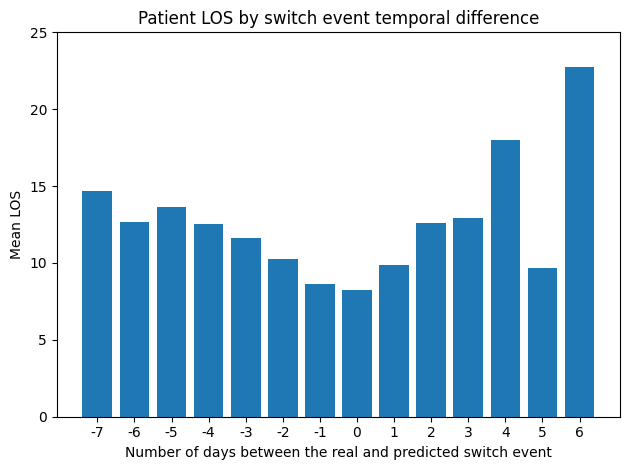

In [55]:
# Decided to go with -7 to 6

labels = ['-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']

lb_los_mean = [14.686875,
 12.656674382716048,
 13.650946649029985,
 12.562466902333323,
 11.64532204931315,
 10.255824657894568,
 8.632213389276703,
 8.25601386556075,
 9.890728635951927,
 12.616377634362184,
 12.894190492667056,
 17.97081886574074,
 9.691493055555556,
 22.719965277777774]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, lb_los_mean)

ax.set_ylabel('Mean LOS')
ax.set_title('Patient LOS by switch event temporal difference')
ax.set_xlabel('Number of days between the real and predicted switch event')

ax.set_ylim(0,25)

ax.set_xticks(x, labels)

fig.tight_layout()

plt.show()